# To run this notebook you need to clone this repository to be imported in the second cell:

## https://github.com/garrettkatz/rnn-fxpts.git

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import sys
import rnn_fxpts as rfx
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA


from indl.display import turbo_cmap
from sklearn.model_selection import train_test_split

# Testing RFX

In [3]:
N0 = 2
W0 = 1.25*np.eye(N0) + 0.1*np.random.randn(N0,N0)

In [4]:
fxpts0, fiber0 = rfx.run_solver(W0)

In [5]:
print(fxpts0.shape, fiber0.shape)

(2, 9) (3, 112)


(-1.5, 1.5)

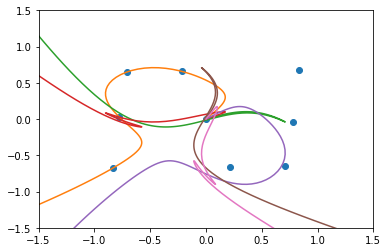

In [6]:
plt.plot(fxpts0[0], fxpts0[1], 'o')
plt.plot(fiber0[0], fiber0[1])
plt.plot(fiber0[1], fiber0[2])
plt.plot(fiber0[0], fiber0[2])
plt.plot(fiber0[1], fiber0[0])
plt.plot(fiber0[2], fiber0[1])
plt.plot(fiber0[2], fiber0[0])
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))

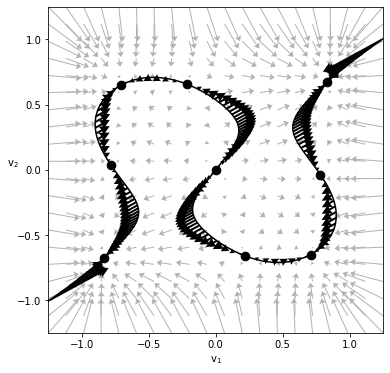

In [7]:
rfx.show_fiber(W0, fxpts0, fiber0)

# Training our model

### Loading data (New version)

In [ ]:
# You can change the data_path according to the local setup

In [5]:
data_path = Path.cwd().parent.parent / 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Finished downloading and extracting data.


Traceback (most recent call last):
  File "c:\users\alireza\miniconda3\envs\dl\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\alireza\miniconda3\envs\dl\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Alireza\miniconda3\envs\dl\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "c:\users\alireza\miniconda3\envs\dl\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "c:\users\alireza\miniconda3\envs\dl\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\Alireza\.kaggle. Or use the environment method.


In [4]:
from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc

load_kwargs = {
    'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

In [5]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y_new, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
Y_class = tf.keras.utils.to_categorical(Y_new, num_classes=8)


Importing session sra3_1_j_050_00+


### Loading data (Old version)

In [12]:
sess_id_old = sess_info['exp_code'][:-1] + "_v1+"
print(f"\nImporting session {sess_id_old}")
X_rates_old, Y_old, ax_info_old = load_macaque_pfc(data_path, sess_id_old, x_chunk='spikerates', **load_kwargs)
Y_class_old = tf.keras.utils.to_categorical(Y_old, num_classes=8)


Importing session sra3_1_j_050_00_v1+


In [12]:
print(X_rates.shape, X_rates_old.shape)

(285, 36, 171) (285, 32, 171)


### Making the model

In [16]:
from indl.model import parts
from indl.model.helper import check_inputs
from indl.regularizers import KernelLengthRegularizer

@check_inputs
def make_model(
    _input,
    num_classes,
    filt=8,
    kernLength=25,
    ds_rate=10,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.25,
    activation='relu',
    l1_reg=0.000, l2_reg=0.000,
    norm_rate=0.25,
    latent_dim=16,
    return_model=True
):
    
    inputs = _input
    
    input_shape = _input.shape.as_list()
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
    if len(input_shape) < 4:
        input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv2D(filt, (1, kernLength), padding='valid', data_format=None,
                                dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
                                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.DepthwiseConv2D((_y.shape.as_list()[1], 1), padding='valid',
                                      depth_multiplier=1, data_format=None, dilation_rate=(1, 1),
                                      activation=None, use_bias=True, depthwise_initializer='glorot_uniform',
                                      bias_initializer='zeros', depthwise_regularizer=None,
                                      bias_regularizer=None, activity_regularizer=None,
                                      depthwise_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.AveragePooling2D(pool_size=(1, ds_rate))(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.Reshape(_y.shape.as_list()[2:])(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [15]:
## Model Parameters
LABEL_SMOOTHING = 0.2

model_kwargs = dict(
    filt=8,
    kernLength=25,
    ds_rate=9,
    n_rnn=64,
    n_rnn2=0,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)

### Training

In [14]:
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
BATCH_SIZE = 16
EPOCHS = 180


def get_hists_acc(sess_id, new=True, verbose=1):
    print(f"Processing session {sess_id}...")
    X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=8)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model(
            ds_train.element_spec[0],
            _y.shape[-1],
            **model_kwargs
        )
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        if new:
            best_model_path = f'r2c_lstm_{sess_id}new_split{split_ix}.h5'
        else:
            best_model_path = f'r2c_lstm_{sess_id}old_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"Session {sess_id} overall accuracy: {accuracy}%")
    
    return history, accuracy

#### Train for new dataset

Processing session sra3_1_j_050_00+...
	Split 1 of 10
Train for 16 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.24138, saving model to r2c_lstm_sra3_1_j_050_00+new_split0.h5
16/16 - 9s - loss: 2.1526 - accuracy: 0.1797 - val_loss: 2.1493 - val_accuracy: 0.2414
Epoch 2/180

Epoch 00002: val_accuracy did not improve from 0.24138
16/16 - 2s - loss: 2.0472 - accuracy: 0.3008 - val_loss: 2.1356 - val_accuracy: 0.2414
Epoch 3/180

Epoch 00003: val_accuracy did not improve from 0.24138
16/16 - 2s - loss: 1.9595 - accuracy: 0.3633 - val_loss: 2.1142 - val_accuracy: 0.2414
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.24138 to 0.37931, saving model to r2c_lstm_sra3_1_j_050_00+new_split0.h5
16/16 - 2s - loss: 1.8321 - accuracy: 0.4375 - val_loss: 2.0812 - val_accuracy: 0.3793
Epoch 5/180

Epoch 00005: val_accuracy improved from 0.37931 to 0.41379, saving model to r2c_lstm_sra3_1_j_050_00+new_split0.h5
16/16 - 2s - loss: 1.7073 - accuracy: 0.

Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.1321 - accuracy: 0.8477 - val_loss: 1.0424 - val_accuracy: 0.8276
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.2037 - accuracy: 0.8438 - val_loss: 1.0755 - val_accuracy: 0.8276
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.1247 - accuracy: 0.8555 - val_loss: 1.0781 - val_accuracy: 0.8621
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.1345 - accuracy: 0.8516 - val_loss: 1.0337 - val_accuracy: 0.8621
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.1673 - accuracy: 0.8164 - val_loss: 1.0206 - val_accuracy: 0.8621
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.1135 - accuracy: 0.8633 - val_loss: 1.0156 - val_accuracy: 0.8621
Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.9

Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.0729 - accuracy: 0.9180 - val_loss: 1.0001 - val_accuracy: 0.9310
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.0972 - accuracy: 0.8789 - val_loss: 1.0217 - val_accuracy: 0.8966
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0669 - accuracy: 0.9062 - val_loss: 1.0368 - val_accuracy: 0.8966
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0781 - accuracy: 0.8945 - val_loss: 1.0078 - val_accuracy: 0.9310
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.0734 - accuracy: 0.9219 - val_loss: 1.0289 - val_accuracy: 0.8966
Epoch 107/180

Epoch 00107: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0607 - accuracy: 0.9102 - val_loss: 1.0293 - val_accuracy: 0.8966
Epoch 108/180

Epoch 00108: val_accuracy did not improve f

Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.96552
16/16 - 2s - loss: 0.9929 - accuracy: 0.9492 - val_loss: 1.0212 - val_accuracy: 0.8966
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.96552
16/16 - 2s - loss: 1.0241 - accuracy: 0.9375 - val_loss: 1.0841 - val_accuracy: 0.8621
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.96552
16/16 - 2s - loss: 1.0219 - accuracy: 0.9414 - val_loss: 1.0619 - val_accuracy: 0.8621
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.96552
16/16 - 2s - loss: 1.0372 - accuracy: 0.9297 - val_loss: 1.0840 - val_accuracy: 0.8621
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.96552
16/16 - 1s - loss: 1.0345 - accuracy: 0.9062 - val_loss: 1.0941 - val_accuracy: 0.8621
Epoch 159/180

Epoch 00159: val_accuracy did not improve from 0.96552
16/16 - 2s - loss: 1.0094 - accuracy: 0.9375 - val_loss: 1.0992 - val_accuracy: 0.8621
Epoch 160/180

Epoch 00160: val_accuracy did not improve f

Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.89655
16/16 - 2s - loss: 1.2469 - accuracy: 0.7734 - val_loss: 1.3094 - val_accuracy: 0.8276
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.89655
16/16 - 2s - loss: 1.2492 - accuracy: 0.7422 - val_loss: 1.2608 - val_accuracy: 0.8966
Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.89655
16/16 - 2s - loss: 1.2580 - accuracy: 0.7773 - val_loss: 1.2629 - val_accuracy: 0.7931
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.89655
16/16 - 2s - loss: 1.1889 - accuracy: 0.8242 - val_loss: 1.2171 - val_accuracy: 0.8966
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.89655
16/16 - 2s - loss: 1.2336 - accuracy: 0.7969 - val_loss: 1.2008 - val_accuracy: 0.8621
Epoch 27/180

Epoch 00027: val_accuracy did not improve from 0.89655
16/16 - 2s - loss: 1.2108 - accuracy: 0.7656 - val_loss: 1.1814 - val_accuracy: 0.8276
Epoch 28/180

Epoch 00028: val_accuracy improved from 0.89655 to

Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.0836 - accuracy: 0.8789 - val_loss: 1.1847 - val_accuracy: 0.8276
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0878 - accuracy: 0.8906 - val_loss: 1.1421 - val_accuracy: 0.8621
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0853 - accuracy: 0.8672 - val_loss: 1.1622 - val_accuracy: 0.8276
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.1069 - accuracy: 0.8789 - val_loss: 1.1999 - val_accuracy: 0.8276
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0525 - accuracy: 0.9258 - val_loss: 1.1288 - val_accuracy: 0.8621
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0712 - accuracy: 0.9023 - val_loss: 1.1671 - val_accuracy: 0.7586
Epoch 81/180

Epoch 00081: val_accuracy did not improve from 0.9

Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0261 - accuracy: 0.9180 - val_loss: 1.1386 - val_accuracy: 0.8621
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0579 - accuracy: 0.9102 - val_loss: 1.1392 - val_accuracy: 0.8621
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0362 - accuracy: 0.9062 - val_loss: 1.1272 - val_accuracy: 0.8276
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0540 - accuracy: 0.9180 - val_loss: 1.1341 - val_accuracy: 0.8966
Epoch 132/180

Epoch 00132: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 0.9890 - accuracy: 0.9453 - val_loss: 1.1413 - val_accuracy: 0.8621
Epoch 133/180

Epoch 00133: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.0510 - accuracy: 0.9180 - val_loss: 1.1581 - val_accuracy: 0.8621
Epoch 134/180

Epoch 00134: val_accuracy did not improve f

	Split 3 of 10
Train for 16 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.24138, saving model to r2c_lstm_sra3_1_j_050_00+new_split2.h5
16/16 - 8s - loss: 2.1294 - accuracy: 0.2031 - val_loss: 2.1481 - val_accuracy: 0.2414
Epoch 2/180

Epoch 00002: val_accuracy did not improve from 0.24138
16/16 - 2s - loss: 2.0341 - accuracy: 0.3008 - val_loss: 2.1325 - val_accuracy: 0.2414
Epoch 3/180

Epoch 00003: val_accuracy improved from 0.24138 to 0.31034, saving model to r2c_lstm_sra3_1_j_050_00+new_split2.h5
16/16 - 2s - loss: 1.9387 - accuracy: 0.3672 - val_loss: 2.1075 - val_accuracy: 0.3103
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.31034 to 0.48276, saving model to r2c_lstm_sra3_1_j_050_00+new_split2.h5
16/16 - 2s - loss: 1.8212 - accuracy: 0.3672 - val_loss: 2.0719 - val_accuracy: 0.4828
Epoch 5/180

Epoch 00005: val_accuracy improved from 0.48276 to 0.58621, saving model to r2c_lstm_sra3_1_j_050_00+new_split2.h5
16/16 - 2s - loss: 

Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.1392 - accuracy: 0.8594 - val_loss: 1.0666 - val_accuracy: 0.8966
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.1546 - accuracy: 0.8125 - val_loss: 1.0728 - val_accuracy: 0.8966
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.1270 - accuracy: 0.8672 - val_loss: 1.0687 - val_accuracy: 0.8621
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.1138 - accuracy: 0.8438 - val_loss: 1.0667 - val_accuracy: 0.8621
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0879 - accuracy: 0.8906 - val_loss: 1.0906 - val_accuracy: 0.8621
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.1068 - accuracy: 0.8711 - val_loss: 1.0826 - val_accuracy: 0.8621
Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.9

Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.1115 - accuracy: 0.8633 - val_loss: 1.1394 - val_accuracy: 0.8276
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0469 - accuracy: 0.9023 - val_loss: 1.1457 - val_accuracy: 0.7931
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0738 - accuracy: 0.8906 - val_loss: 1.1295 - val_accuracy: 0.8621
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0969 - accuracy: 0.8750 - val_loss: 1.1017 - val_accuracy: 0.8966
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.1436 - accuracy: 0.8594 - val_loss: 1.1131 - val_accuracy: 0.8966
Epoch 107/180

Epoch 00107: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0771 - accuracy: 0.8945 - val_loss: 1.1257 - val_accuracy: 0.8621
Epoch 108/180

Epoch 00108: val_accuracy did not improve f

Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.0395 - accuracy: 0.9180 - val_loss: 1.1433 - val_accuracy: 0.8276
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0503 - accuracy: 0.9023 - val_loss: 1.1503 - val_accuracy: 0.7586
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0330 - accuracy: 0.9336 - val_loss: 1.1264 - val_accuracy: 0.8276
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 1.0143 - accuracy: 0.9297 - val_loss: 1.1598 - val_accuracy: 0.7931
Epoch 159/180

Epoch 00159: val_accuracy did not improve from 0.93103
16/16 - 1s - loss: 1.0779 - accuracy: 0.8945 - val_loss: 1.1410 - val_accuracy: 0.8621
Epoch 160/180

Epoch 00160: val_accuracy did not improve from 0.93103
16/16 - 2s - loss: 0.9949 - accuracy: 0.9414 - val_loss: 1.1796 - val_accuracy: 0.8621
Epoch 161/180

Epoch 00161: val_accuracy did not improve f

Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.68966
16/16 - 2s - loss: 1.2218 - accuracy: 0.7969 - val_loss: 1.2944 - val_accuracy: 0.6552
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.68966
16/16 - 1s - loss: 1.1801 - accuracy: 0.8203 - val_loss: 1.2996 - val_accuracy: 0.6207
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.68966
16/16 - 2s - loss: 1.1989 - accuracy: 0.7969 - val_loss: 1.2854 - val_accuracy: 0.6207
Epoch 27/180

Epoch 00027: val_accuracy did not improve from 0.68966
16/16 - 2s - loss: 1.1939 - accuracy: 0.8047 - val_loss: 1.2752 - val_accuracy: 0.6207
Epoch 28/180

Epoch 00028: val_accuracy did not improve from 0.68966
16/16 - 1s - loss: 1.1761 - accuracy: 0.8086 - val_loss: 1.2901 - val_accuracy: 0.6207
Epoch 29/180

Epoch 00029: val_accuracy did not improve from 0.68966
16/16 - 2s - loss: 1.1838 - accuracy: 0.8203 - val_loss: 1.2811 - val_accuracy: 0.6207
Epoch 30/180

Epoch 00030: val_accuracy did not improve from 0.6

Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.75862
16/16 - 2s - loss: 1.0906 - accuracy: 0.8594 - val_loss: 1.4296 - val_accuracy: 0.6897
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.75862
16/16 - 2s - loss: 1.0832 - accuracy: 0.8828 - val_loss: 1.4227 - val_accuracy: 0.6552
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.75862
16/16 - 2s - loss: 1.0949 - accuracy: 0.8828 - val_loss: 1.4214 - val_accuracy: 0.6552
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.75862
16/16 - 2s - loss: 1.0843 - accuracy: 0.8828 - val_loss: 1.3926 - val_accuracy: 0.6897
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.75862
16/16 - 2s - loss: 1.0926 - accuracy: 0.8906 - val_loss: 1.4005 - val_accuracy: 0.6897
Epoch 81/180

Epoch 00081: val_accuracy did not improve from 0.75862
16/16 - 2s - loss: 1.0704 - accuracy: 0.8828 - val_loss: 1.4112 - val_accuracy: 0.6552
Epoch 82/180

Epoch 00082: val_accuracy did not improve from 0.7

Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.75862
16/16 - 1s - loss: 1.0000 - accuracy: 0.9414 - val_loss: 1.3746 - val_accuracy: 0.6897
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.75862
16/16 - 2s - loss: 1.0116 - accuracy: 0.9414 - val_loss: 1.3767 - val_accuracy: 0.6897
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.75862
16/16 - 1s - loss: 1.0539 - accuracy: 0.8906 - val_loss: 1.3804 - val_accuracy: 0.6552
Epoch 132/180

Epoch 00132: val_accuracy did not improve from 0.75862
16/16 - 1s - loss: 0.9995 - accuracy: 0.9414 - val_loss: 1.3943 - val_accuracy: 0.7241
Epoch 133/180

Epoch 00133: val_accuracy did not improve from 0.75862
16/16 - 2s - loss: 1.0153 - accuracy: 0.9492 - val_loss: 1.3672 - val_accuracy: 0.7241
Epoch 134/180

Epoch 00134: val_accuracy did not improve from 0.75862
16/16 - 1s - loss: 0.9858 - accuracy: 0.9453 - val_loss: 1.4522 - val_accuracy: 0.6897
Epoch 135/180

Epoch 00135: val_accuracy did not improve f


Epoch 00001: val_accuracy improved from -inf to 0.24138, saving model to r2c_lstm_sra3_1_j_050_00+new_split4.h5
16/16 - 9s - loss: 2.1236 - accuracy: 0.1992 - val_loss: 2.1484 - val_accuracy: 0.2414
Epoch 2/180

Epoch 00002: val_accuracy did not improve from 0.24138
16/16 - 2s - loss: 2.0322 - accuracy: 0.2734 - val_loss: 2.1325 - val_accuracy: 0.2414
Epoch 3/180

Epoch 00003: val_accuracy did not improve from 0.24138
16/16 - 2s - loss: 1.9352 - accuracy: 0.3711 - val_loss: 2.1083 - val_accuracy: 0.2414
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.24138 to 0.41379, saving model to r2c_lstm_sra3_1_j_050_00+new_split4.h5
16/16 - 2s - loss: 1.8118 - accuracy: 0.4570 - val_loss: 2.0685 - val_accuracy: 0.4138
Epoch 5/180

Epoch 00005: val_accuracy improved from 0.41379 to 0.48276, saving model to r2c_lstm_sra3_1_j_050_00+new_split4.h5
16/16 - 2s - loss: 1.7055 - accuracy: 0.5078 - val_loss: 2.0153 - val_accuracy: 0.4828
Epoch 6/180

Epoch 00006: val_accuracy improved from 0.48276

Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.1371 - accuracy: 0.8633 - val_loss: 1.2641 - val_accuracy: 0.7586
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.82759
16/16 - 1s - loss: 1.0814 - accuracy: 0.9023 - val_loss: 1.2467 - val_accuracy: 0.7586
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.1372 - accuracy: 0.8477 - val_loss: 1.2534 - val_accuracy: 0.7586
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.1616 - accuracy: 0.8359 - val_loss: 1.2063 - val_accuracy: 0.7586
Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.1680 - accuracy: 0.8477 - val_loss: 1.2717 - val_accuracy: 0.7586
Epoch 56/180

Epoch 00056: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.0851 - accuracy: 0.8750 - val_loss: 1.2193 - val_accuracy: 0.7931
Epoch 57/180

Epoch 00057: val_accuracy did not improve from 0.8

Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.82759
16/16 - 1s - loss: 1.0568 - accuracy: 0.8906 - val_loss: 1.3040 - val_accuracy: 0.7241
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.82759
16/16 - 1s - loss: 1.0532 - accuracy: 0.8984 - val_loss: 1.3333 - val_accuracy: 0.7241
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.0306 - accuracy: 0.9219 - val_loss: 1.3364 - val_accuracy: 0.7586
Epoch 107/180

Epoch 00107: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.0200 - accuracy: 0.9375 - val_loss: 1.3184 - val_accuracy: 0.7241
Epoch 108/180

Epoch 00108: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.0469 - accuracy: 0.9258 - val_loss: 1.2883 - val_accuracy: 0.7586
Epoch 109/180

Epoch 00109: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.0701 - accuracy: 0.9141 - val_loss: 1.3166 - val_accuracy: 0.7586
Epoch 110/180

Epoch 00110: val_accuracy did not improve f

Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.0204 - accuracy: 0.9297 - val_loss: 1.2610 - val_accuracy: 0.7931
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.0403 - accuracy: 0.9062 - val_loss: 1.2392 - val_accuracy: 0.8276
Epoch 159/180

Epoch 00159: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 1.0599 - accuracy: 0.9141 - val_loss: 1.2380 - val_accuracy: 0.8276
Epoch 160/180

Epoch 00160: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 0.9959 - accuracy: 0.9375 - val_loss: 1.2865 - val_accuracy: 0.7931
Epoch 161/180

Epoch 00161: val_accuracy did not improve from 0.82759
16/16 - 2s - loss: 0.9901 - accuracy: 0.9492 - val_loss: 1.2719 - val_accuracy: 0.7931
Epoch 162/180

Epoch 00162: val_accuracy improved from 0.82759 to 0.86207, saving model to r2c_lstm_sra3_1_j_050_00+new_split4.h5
16/16 - 2s - loss: 1.0448 - accuracy: 0.9297 - val_loss: 1.2451 - val_accuracy: 0.862

Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.75000
16/16 - 2s - loss: 1.2362 - accuracy: 0.8086 - val_loss: 1.3053 - val_accuracy: 0.7143
Epoch 27/180

Epoch 00027: val_accuracy did not improve from 0.75000
16/16 - 2s - loss: 1.1986 - accuracy: 0.8086 - val_loss: 1.3156 - val_accuracy: 0.6071
Epoch 28/180

Epoch 00028: val_accuracy did not improve from 0.75000
16/16 - 2s - loss: 1.2250 - accuracy: 0.7656 - val_loss: 1.3064 - val_accuracy: 0.6786
Epoch 29/180

Epoch 00029: val_accuracy did not improve from 0.75000
16/16 - 2s - loss: 1.2062 - accuracy: 0.7891 - val_loss: 1.2655 - val_accuracy: 0.7143
Epoch 30/180

Epoch 00030: val_accuracy did not improve from 0.75000
16/16 - 2s - loss: 1.1899 - accuracy: 0.7969 - val_loss: 1.2703 - val_accuracy: 0.6786
Epoch 31/180

Epoch 00031: val_accuracy did not improve from 0.75000
16/16 - 2s - loss: 1.1812 - accuracy: 0.8281 - val_loss: 1.2825 - val_accuracy: 0.6429
Epoch 32/180

Epoch 00032: val_accuracy did not improve from 0.7

Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.78571
16/16 - 2s - loss: 1.0571 - accuracy: 0.9180 - val_loss: 1.3440 - val_accuracy: 0.7500
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.78571
16/16 - 2s - loss: 1.0783 - accuracy: 0.8945 - val_loss: 1.3283 - val_accuracy: 0.7500
Epoch 81/180

Epoch 00081: val_accuracy did not improve from 0.78571
16/16 - 2s - loss: 1.0695 - accuracy: 0.9023 - val_loss: 1.2926 - val_accuracy: 0.7500
Epoch 82/180

Epoch 00082: val_accuracy did not improve from 0.78571
16/16 - 2s - loss: 1.0435 - accuracy: 0.9023 - val_loss: 1.2952 - val_accuracy: 0.7500
Epoch 83/180

Epoch 00083: val_accuracy did not improve from 0.78571
16/16 - 1s - loss: 1.0607 - accuracy: 0.9297 - val_loss: 1.3104 - val_accuracy: 0.7143
Epoch 84/180

Epoch 00084: val_accuracy did not improve from 0.78571
16/16 - 1s - loss: 1.1328 - accuracy: 0.8633 - val_loss: 1.3272 - val_accuracy: 0.7143
Epoch 85/180

Epoch 00085: val_accuracy did not improve from 0.7

Epoch 132/180

Epoch 00132: val_accuracy did not improve from 0.78571
16/16 - 1s - loss: 1.0846 - accuracy: 0.9023 - val_loss: 1.3355 - val_accuracy: 0.7500
Epoch 133/180

Epoch 00133: val_accuracy did not improve from 0.78571
16/16 - 1s - loss: 1.0586 - accuracy: 0.9258 - val_loss: 1.2962 - val_accuracy: 0.7500
Epoch 134/180

Epoch 00134: val_accuracy did not improve from 0.78571
16/16 - 2s - loss: 1.0184 - accuracy: 0.9375 - val_loss: 1.2791 - val_accuracy: 0.7857
Epoch 135/180

Epoch 00135: val_accuracy did not improve from 0.78571
16/16 - 2s - loss: 1.0498 - accuracy: 0.9219 - val_loss: 1.2599 - val_accuracy: 0.7857
Epoch 136/180

Epoch 00136: val_accuracy did not improve from 0.78571
16/16 - 2s - loss: 1.0224 - accuracy: 0.9141 - val_loss: 1.2799 - val_accuracy: 0.7500
Epoch 137/180

Epoch 00137: val_accuracy improved from 0.78571 to 0.82143, saving model to r2c_lstm_sra3_1_j_050_00+new_split5.h5
16/16 - 2s - loss: 1.0977 - accuracy: 0.8945 - val_loss: 1.2694 - val_accuracy: 0.821

Epoch 4/180

Epoch 00004: val_accuracy improved from 0.25000 to 0.39286, saving model to r2c_lstm_sra3_1_j_050_00+new_split6.h5
16/16 - 2s - loss: 1.8102 - accuracy: 0.4336 - val_loss: 2.0773 - val_accuracy: 0.3929
Epoch 5/180

Epoch 00005: val_accuracy improved from 0.39286 to 0.50000, saving model to r2c_lstm_sra3_1_j_050_00+new_split6.h5
16/16 - 2s - loss: 1.6879 - accuracy: 0.4883 - val_loss: 2.0301 - val_accuracy: 0.5000
Epoch 6/180

Epoch 00006: val_accuracy improved from 0.50000 to 0.53571, saving model to r2c_lstm_sra3_1_j_050_00+new_split6.h5
16/16 - 2s - loss: 1.6069 - accuracy: 0.5273 - val_loss: 1.9652 - val_accuracy: 0.5357
Epoch 7/180

Epoch 00007: val_accuracy improved from 0.53571 to 0.64286, saving model to r2c_lstm_sra3_1_j_050_00+new_split6.h5
16/16 - 2s - loss: 1.5532 - accuracy: 0.5703 - val_loss: 1.9109 - val_accuracy: 0.6429
Epoch 8/180

Epoch 00008: val_accuracy did not improve from 0.64286
16/16 - 2s - loss: 1.4990 - accuracy: 0.6250 - val_loss: 1.8647 - val_ac

Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.1141 - accuracy: 0.8633 - val_loss: 1.2420 - val_accuracy: 0.7500
Epoch 56/180

Epoch 00056: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.0893 - accuracy: 0.8867 - val_loss: 1.1730 - val_accuracy: 0.7500
Epoch 57/180

Epoch 00057: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.1501 - accuracy: 0.8398 - val_loss: 1.2193 - val_accuracy: 0.7143
Epoch 58/180

Epoch 00058: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.1104 - accuracy: 0.8711 - val_loss: 1.1555 - val_accuracy: 0.8214
Epoch 59/180

Epoch 00059: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.1251 - accuracy: 0.8711 - val_loss: 1.1479 - val_accuracy: 0.8214
Epoch 60/180

Epoch 00060: val_accuracy did not improve from 0.82143
16/16 - 1s - loss: 1.1479 - accuracy: 0.8516 - val_loss: 1.1344 - val_accuracy: 0.8214
Epoch 61/180

Epoch 00061: val_accuracy did not improve from 0.8

Epoch 108/180

Epoch 00108: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.0524 - accuracy: 0.9102 - val_loss: 1.1796 - val_accuracy: 0.7500
Epoch 109/180

Epoch 00109: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.0734 - accuracy: 0.8750 - val_loss: 1.1503 - val_accuracy: 0.7500
Epoch 110/180

Epoch 00110: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.0726 - accuracy: 0.9023 - val_loss: 1.1589 - val_accuracy: 0.7500
Epoch 111/180

Epoch 00111: val_accuracy did not improve from 0.82143
16/16 - 1s - loss: 1.0429 - accuracy: 0.9102 - val_loss: 1.1604 - val_accuracy: 0.7857
Epoch 112/180

Epoch 00112: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.0396 - accuracy: 0.9219 - val_loss: 1.1755 - val_accuracy: 0.7857
Epoch 113/180

Epoch 00113: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.0640 - accuracy: 0.8945 - val_loss: 1.1951 - val_accuracy: 0.7500
Epoch 114/180

Epoch 00114: val_accuracy did not improve f

Epoch 161/180

Epoch 00161: val_accuracy did not improve from 0.82143
16/16 - 1s - loss: 1.0260 - accuracy: 0.9062 - val_loss: 1.2160 - val_accuracy: 0.7143
Epoch 162/180

Epoch 00162: val_accuracy did not improve from 0.82143
16/16 - 1s - loss: 1.0016 - accuracy: 0.9414 - val_loss: 1.2055 - val_accuracy: 0.7500
Epoch 163/180

Epoch 00163: val_accuracy did not improve from 0.82143
16/16 - 1s - loss: 1.0537 - accuracy: 0.9180 - val_loss: 1.3009 - val_accuracy: 0.7143
Epoch 164/180

Epoch 00164: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.0013 - accuracy: 0.9258 - val_loss: 1.3090 - val_accuracy: 0.7143
Epoch 165/180

Epoch 00165: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.0275 - accuracy: 0.9375 - val_loss: 1.2277 - val_accuracy: 0.7500
Epoch 166/180

Epoch 00166: val_accuracy did not improve from 0.82143
16/16 - 2s - loss: 1.0334 - accuracy: 0.9336 - val_loss: 1.2773 - val_accuracy: 0.7500
Epoch 167/180

Epoch 00167: val_accuracy did not improve f

Epoch 30/180

Epoch 00030: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.1869 - accuracy: 0.7930 - val_loss: 1.1486 - val_accuracy: 0.9286
Epoch 31/180

Epoch 00031: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.1994 - accuracy: 0.8125 - val_loss: 1.1431 - val_accuracy: 0.8571
Epoch 32/180

Epoch 00032: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.2015 - accuracy: 0.7812 - val_loss: 1.1719 - val_accuracy: 0.8929
Epoch 33/180

Epoch 00033: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.1653 - accuracy: 0.8281 - val_loss: 1.1913 - val_accuracy: 0.8214
Epoch 34/180

Epoch 00034: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.1849 - accuracy: 0.8320 - val_loss: 1.1448 - val_accuracy: 0.8214
Epoch 35/180

Epoch 00035: val_accuracy did not improve from 0.92857
16/16 - 1s - loss: 1.2000 - accuracy: 0.7852 - val_loss: 1.1415 - val_accuracy: 0.8571
Epoch 36/180

Epoch 00036: val_accuracy did not improve from 0.9

Epoch 83/180

Epoch 00083: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.0423 - accuracy: 0.9219 - val_loss: 1.1563 - val_accuracy: 0.8571
Epoch 84/180

Epoch 00084: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.0945 - accuracy: 0.8789 - val_loss: 1.1371 - val_accuracy: 0.8571
Epoch 85/180

Epoch 00085: val_accuracy did not improve from 0.92857
16/16 - 1s - loss: 1.0924 - accuracy: 0.8789 - val_loss: 1.1050 - val_accuracy: 0.8571
Epoch 86/180

Epoch 00086: val_accuracy did not improve from 0.92857
16/16 - 1s - loss: 1.0548 - accuracy: 0.9062 - val_loss: 1.2097 - val_accuracy: 0.7857
Epoch 87/180

Epoch 00087: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.0982 - accuracy: 0.8594 - val_loss: 1.2094 - val_accuracy: 0.7857
Epoch 88/180

Epoch 00088: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.0734 - accuracy: 0.8984 - val_loss: 1.1666 - val_accuracy: 0.8571
Epoch 89/180

Epoch 00089: val_accuracy did not improve from 0.9

Epoch 136/180

Epoch 00136: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.0393 - accuracy: 0.9219 - val_loss: 1.2961 - val_accuracy: 0.7143
Epoch 137/180

Epoch 00137: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.0482 - accuracy: 0.9219 - val_loss: 1.2641 - val_accuracy: 0.7500
Epoch 138/180

Epoch 00138: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.0322 - accuracy: 0.9336 - val_loss: 1.3272 - val_accuracy: 0.7500
Epoch 139/180

Epoch 00139: val_accuracy did not improve from 0.92857
16/16 - 1s - loss: 1.0283 - accuracy: 0.9258 - val_loss: 1.2759 - val_accuracy: 0.7500
Epoch 140/180

Epoch 00140: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.0225 - accuracy: 0.9141 - val_loss: 1.1931 - val_accuracy: 0.8214
Epoch 141/180

Epoch 00141: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.0046 - accuracy: 0.9453 - val_loss: 1.1986 - val_accuracy: 0.7857
Epoch 142/180

Epoch 00142: val_accuracy did not improve f

Epoch 7/180

Epoch 00007: val_accuracy improved from 0.50000 to 0.53571, saving model to r2c_lstm_sra3_1_j_050_00+new_split8.h5
16/16 - 2s - loss: 1.5624 - accuracy: 0.5352 - val_loss: 1.9096 - val_accuracy: 0.5357
Epoch 8/180

Epoch 00008: val_accuracy did not improve from 0.53571
16/16 - 2s - loss: 1.4817 - accuracy: 0.6289 - val_loss: 1.8530 - val_accuracy: 0.5000
Epoch 9/180

Epoch 00009: val_accuracy did not improve from 0.53571
16/16 - 2s - loss: 1.4421 - accuracy: 0.6445 - val_loss: 1.7860 - val_accuracy: 0.5357
Epoch 10/180

Epoch 00010: val_accuracy improved from 0.53571 to 0.71429, saving model to r2c_lstm_sra3_1_j_050_00+new_split8.h5
16/16 - 2s - loss: 1.4057 - accuracy: 0.6289 - val_loss: 1.7424 - val_accuracy: 0.7143
Epoch 11/180

Epoch 00011: val_accuracy did not improve from 0.71429
16/16 - 2s - loss: 1.3853 - accuracy: 0.6680 - val_loss: 1.6953 - val_accuracy: 0.7143
Epoch 12/180

Epoch 00012: val_accuracy improved from 0.71429 to 0.75000, saving model to r2c_lstm_sra3

Epoch 57/180

Epoch 00057: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.1415 - accuracy: 0.8320 - val_loss: 1.0599 - val_accuracy: 0.8929
Epoch 58/180

Epoch 00058: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.1307 - accuracy: 0.8438 - val_loss: 1.0810 - val_accuracy: 0.8571
Epoch 59/180

Epoch 00059: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.1290 - accuracy: 0.8516 - val_loss: 1.0917 - val_accuracy: 0.8571
Epoch 60/180

Epoch 00060: val_accuracy did not improve from 0.92857
16/16 - 2s - loss: 1.1475 - accuracy: 0.8359 - val_loss: 1.0640 - val_accuracy: 0.8929
Epoch 61/180

Epoch 00061: val_accuracy improved from 0.92857 to 0.96429, saving model to r2c_lstm_sra3_1_j_050_00+new_split8.h5
16/16 - 2s - loss: 1.1919 - accuracy: 0.7930 - val_loss: 1.0090 - val_accuracy: 0.9643
Epoch 62/180

Epoch 00062: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.1059 - accuracy: 0.8672 - val_loss: 1.0378 - val_accuracy: 0.8929
Epoc


Epoch 00109: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.0700 - accuracy: 0.8906 - val_loss: 1.0200 - val_accuracy: 0.8929
Epoch 110/180

Epoch 00110: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.0492 - accuracy: 0.9023 - val_loss: 0.9974 - val_accuracy: 0.8929
Epoch 111/180

Epoch 00111: val_accuracy did not improve from 0.96429
16/16 - 1s - loss: 1.0723 - accuracy: 0.9062 - val_loss: 0.9848 - val_accuracy: 0.9643
Epoch 112/180

Epoch 00112: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.0617 - accuracy: 0.9062 - val_loss: 0.9960 - val_accuracy: 0.8929
Epoch 113/180

Epoch 00113: val_accuracy did not improve from 0.96429
16/16 - 1s - loss: 1.0499 - accuracy: 0.9141 - val_loss: 1.0536 - val_accuracy: 0.8571
Epoch 114/180

Epoch 00114: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.0349 - accuracy: 0.8984 - val_loss: 1.0812 - val_accuracy: 0.8929
Epoch 115/180

Epoch 00115: val_accuracy did not improve from 0.96429
16

Epoch 162/180

Epoch 00162: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.0353 - accuracy: 0.9375 - val_loss: 1.0026 - val_accuracy: 0.9286
Epoch 163/180

Epoch 00163: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.0414 - accuracy: 0.9219 - val_loss: 0.9856 - val_accuracy: 0.9286
Epoch 164/180

Epoch 00164: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.0214 - accuracy: 0.9180 - val_loss: 1.0249 - val_accuracy: 0.9286
Epoch 165/180

Epoch 00165: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.0614 - accuracy: 0.8906 - val_loss: 1.0023 - val_accuracy: 0.9286
Epoch 166/180

Epoch 00166: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.0668 - accuracy: 0.9023 - val_loss: 1.0147 - val_accuracy: 0.8929
Epoch 167/180

Epoch 00167: val_accuracy did not improve from 0.96429
16/16 - 2s - loss: 1.0724 - accuracy: 0.8984 - val_loss: 0.9918 - val_accuracy: 0.9286
Epoch 168/180

Epoch 00168: val_accuracy did not improve f

Epoch 30/180

Epoch 00030: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.2040 - accuracy: 0.7891 - val_loss: 1.1346 - val_accuracy: 0.7857
Epoch 31/180

Epoch 00031: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.2278 - accuracy: 0.7695 - val_loss: 1.1372 - val_accuracy: 0.7500
Epoch 32/180

Epoch 00032: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.2090 - accuracy: 0.7812 - val_loss: 1.1274 - val_accuracy: 0.7500
Epoch 33/180

Epoch 00033: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.2145 - accuracy: 0.7695 - val_loss: 1.1209 - val_accuracy: 0.7857
Epoch 34/180

Epoch 00034: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.1668 - accuracy: 0.8320 - val_loss: 1.1387 - val_accuracy: 0.7500
Epoch 35/180

Epoch 00035: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.2122 - accuracy: 0.7617 - val_loss: 1.1239 - val_accuracy: 0.7857
Epoch 36/180

Epoch 00036: val_accuracy did not improve from 0.8

Epoch 83/180

Epoch 00083: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.0517 - accuracy: 0.9219 - val_loss: 1.1399 - val_accuracy: 0.7857
Epoch 84/180

Epoch 00084: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.1224 - accuracy: 0.8750 - val_loss: 1.1483 - val_accuracy: 0.7500
Epoch 85/180

Epoch 00085: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.1075 - accuracy: 0.8672 - val_loss: 1.1815 - val_accuracy: 0.7857
Epoch 86/180

Epoch 00086: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.1050 - accuracy: 0.8906 - val_loss: 1.1585 - val_accuracy: 0.7857
Epoch 87/180

Epoch 00087: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.0937 - accuracy: 0.8789 - val_loss: 1.1273 - val_accuracy: 0.8571
Epoch 88/180

Epoch 00088: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.0989 - accuracy: 0.8516 - val_loss: 1.1615 - val_accuracy: 0.7143
Epoch 89/180

Epoch 00089: val_accuracy did not improve from 0.8

Epoch 136/180

Epoch 00136: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.0647 - accuracy: 0.9102 - val_loss: 1.1673 - val_accuracy: 0.7143
Epoch 137/180

Epoch 00137: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.0742 - accuracy: 0.8789 - val_loss: 1.2140 - val_accuracy: 0.7500
Epoch 138/180

Epoch 00138: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.0527 - accuracy: 0.9062 - val_loss: 1.2231 - val_accuracy: 0.7857
Epoch 139/180

Epoch 00139: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.0565 - accuracy: 0.9062 - val_loss: 1.2255 - val_accuracy: 0.7500
Epoch 140/180

Epoch 00140: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.0832 - accuracy: 0.9023 - val_loss: 1.2234 - val_accuracy: 0.7500
Epoch 141/180

Epoch 00141: val_accuracy did not improve from 0.89286
16/16 - 1s - loss: 1.0063 - accuracy: 0.9414 - val_loss: 1.2278 - val_accuracy: 0.7500
Epoch 142/180

Epoch 00142: val_accuracy did not improve f

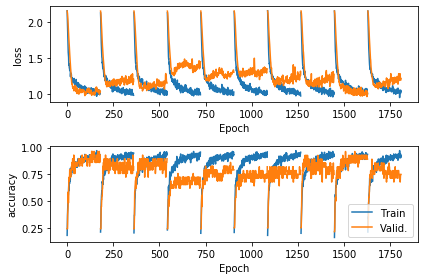

In [45]:
from indl.metrics import quickplot_history

history, accuracy = get_hists_acc(sess_id,new=True, verbose=2)
quickplot_history(history)

#### Train for old dataset

Processing session sra3_1_j_050_00_v1+...
	Split 1 of 10
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.24138, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split0.h5
16/16 - 1s - loss: 2.1563 - accuracy: 0.1953 - val_loss: 2.1491 - val_accuracy: 0.2414
Epoch 2/180

Epoch 00002: val_accuracy improved from 0.24138 to 0.27586, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split0.h5
16/16 - 0s - loss: 2.0469 - accuracy: 0.2969 - val_loss: 2.1327 - val_accuracy: 0.2759
Epoch 3/180

Epoch 00003: val_accuracy improved from 0.27586 to 0.31034, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split0.h5
16/16 - 0s - loss: 1.9322 - accuracy: 0.3398 - val_loss: 2.1060 - val_accuracy: 0.3103
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.31034 to 0.44828, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split0.h5
16/16 - 0s - loss: 1.8088 - accuracy: 0.4414 - val_loss: 2.0651 - val_accuracy: 0.4483
Epoch 5/180

Epoch 00005: val_accuracy improved from 0.44828 to 0.51724, s

Epoch 48/180

Epoch 00048: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2130 - accuracy: 0.7734 - val_loss: 1.0845 - val_accuracy: 0.8621
Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2313 - accuracy: 0.7773 - val_loss: 1.0940 - val_accuracy: 0.8276
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2175 - accuracy: 0.7461 - val_loss: 1.1045 - val_accuracy: 0.8276
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2331 - accuracy: 0.7695 - val_loss: 1.1035 - val_accuracy: 0.8276
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2554 - accuracy: 0.7422 - val_loss: 1.1385 - val_accuracy: 0.7931
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2229 - accuracy: 0.7539 - val_loss: 1.1393 - val_accuracy: 0.7586
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.8

Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.2161 - accuracy: 0.8047 - val_loss: 1.1393 - val_accuracy: 0.7241
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1963 - accuracy: 0.8008 - val_loss: 1.1115 - val_accuracy: 0.8621
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1481 - accuracy: 0.8398 - val_loss: 1.0806 - val_accuracy: 0.8621
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1288 - accuracy: 0.8438 - val_loss: 1.0513 - val_accuracy: 0.8966
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1328 - accuracy: 0.8633 - val_loss: 1.0546 - val_accuracy: 0.8966
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1404 - accuracy: 0.8281 - val_loss: 1.1035 - val_accuracy: 0.7586
Epoch 107/180

Epoch 00107: val_accuracy did not improve f

Epoch 153/180

Epoch 00153: val_accuracy did not improve from 0.93103
16/16 - 0s - loss: 1.0879 - accuracy: 0.8828 - val_loss: 1.1068 - val_accuracy: 0.7931
Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.93103
16/16 - 0s - loss: 1.1649 - accuracy: 0.8359 - val_loss: 1.1254 - val_accuracy: 0.7931
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.93103
16/16 - 0s - loss: 1.0929 - accuracy: 0.8672 - val_loss: 1.0743 - val_accuracy: 0.8621
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.93103
16/16 - 0s - loss: 1.0835 - accuracy: 0.8828 - val_loss: 1.0818 - val_accuracy: 0.8966
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.93103
16/16 - 0s - loss: 1.0997 - accuracy: 0.8867 - val_loss: 1.0880 - val_accuracy: 0.8621
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.93103
16/16 - 0s - loss: 1.1291 - accuracy: 0.8477 - val_loss: 1.0602 - val_accuracy: 0.8621
Epoch 159/180

Epoch 00159: val_accuracy did not improve f

Epoch 21/180

Epoch 00021: val_accuracy did not improve from 0.68966
16/16 - 0s - loss: 1.2990 - accuracy: 0.7109 - val_loss: 1.3595 - val_accuracy: 0.6897
Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.68966
16/16 - 0s - loss: 1.3406 - accuracy: 0.6719 - val_loss: 1.3289 - val_accuracy: 0.6897
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.68966
16/16 - 0s - loss: 1.3401 - accuracy: 0.6719 - val_loss: 1.3169 - val_accuracy: 0.6897
Epoch 24/180

Epoch 00024: val_accuracy improved from 0.68966 to 0.72414, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split1.h5
16/16 - 0s - loss: 1.2599 - accuracy: 0.7344 - val_loss: 1.2893 - val_accuracy: 0.7241
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.2859 - accuracy: 0.7031 - val_loss: 1.3210 - val_accuracy: 0.6552
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3113 - accuracy: 0.7070 - val_loss: 1.3021 - val_accuracy: 0.6897
E

Epoch 72/180

Epoch 00072: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1493 - accuracy: 0.8438 - val_loss: 1.2374 - val_accuracy: 0.7241
Epoch 73/180

Epoch 00073: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.2534 - accuracy: 0.7539 - val_loss: 1.3058 - val_accuracy: 0.6897
Epoch 74/180

Epoch 00074: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.2165 - accuracy: 0.7656 - val_loss: 1.2188 - val_accuracy: 0.7931
Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1837 - accuracy: 0.8320 - val_loss: 1.2352 - val_accuracy: 0.8276
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1935 - accuracy: 0.7891 - val_loss: 1.1949 - val_accuracy: 0.7931
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1766 - accuracy: 0.7812 - val_loss: 1.2332 - val_accuracy: 0.8276
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.8

Epoch 124/180

Epoch 00124: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1410 - accuracy: 0.8359 - val_loss: 1.2861 - val_accuracy: 0.7586
Epoch 125/180

Epoch 00125: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1435 - accuracy: 0.8555 - val_loss: 1.2917 - val_accuracy: 0.7586
Epoch 126/180

Epoch 00126: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1226 - accuracy: 0.8828 - val_loss: 1.2937 - val_accuracy: 0.7241
Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1428 - accuracy: 0.8516 - val_loss: 1.3157 - val_accuracy: 0.7241
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1133 - accuracy: 0.8477 - val_loss: 1.2790 - val_accuracy: 0.7586
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1030 - accuracy: 0.8672 - val_loss: 1.2744 - val_accuracy: 0.7586
Epoch 130/180

Epoch 00130: val_accuracy did not improve f

Epoch 177/180

Epoch 00177: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0550 - accuracy: 0.9023 - val_loss: 1.2788 - val_accuracy: 0.7241
Epoch 178/180

Epoch 00178: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0754 - accuracy: 0.8711 - val_loss: 1.2772 - val_accuracy: 0.7931
Epoch 179/180

Epoch 00179: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0689 - accuracy: 0.8945 - val_loss: 1.2745 - val_accuracy: 0.7931
Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1035 - accuracy: 0.8789 - val_loss: 1.2696 - val_accuracy: 0.7931
	Split 3 of 10
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.24138, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split2.h5
16/16 - 1s - loss: 2.1304 - accuracy: 0.2188 - val_loss: 2.1490 - val_accuracy: 0.2414
Epoch 2/180

Epoch 00002: val_accuracy did not improve from 0.24138
16/16 - 0s - loss: 2.0342 - accuracy: 0.2617 - val_loss: 2.1330 - val_accu


Epoch 00045: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.2366 - accuracy: 0.7617 - val_loss: 1.1794 - val_accuracy: 0.7931
Epoch 46/180

Epoch 00046: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.2234 - accuracy: 0.7734 - val_loss: 1.2159 - val_accuracy: 0.7586
Epoch 47/180

Epoch 00047: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.2106 - accuracy: 0.7891 - val_loss: 1.2130 - val_accuracy: 0.7586
Epoch 48/180

Epoch 00048: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1950 - accuracy: 0.8008 - val_loss: 1.2163 - val_accuracy: 0.7586
Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.2131 - accuracy: 0.7734 - val_loss: 1.2179 - val_accuracy: 0.6897
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1962 - accuracy: 0.7852 - val_loss: 1.2327 - val_accuracy: 0.7241
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.79310
16/16 - 

Epoch 98/180

Epoch 00098: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1287 - accuracy: 0.8594 - val_loss: 1.4418 - val_accuracy: 0.6552
Epoch 99/180

Epoch 00099: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1093 - accuracy: 0.8867 - val_loss: 1.3423 - val_accuracy: 0.7241
Epoch 100/180

Epoch 00100: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1273 - accuracy: 0.8633 - val_loss: 1.3775 - val_accuracy: 0.7241
Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1732 - accuracy: 0.8203 - val_loss: 1.3696 - val_accuracy: 0.7241
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1250 - accuracy: 0.8320 - val_loss: 1.2888 - val_accuracy: 0.7586
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1463 - accuracy: 0.8398 - val_loss: 1.3316 - val_accuracy: 0.7241
Epoch 104/180

Epoch 00104: val_accuracy did not improve fro

Epoch 151/180

Epoch 00151: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1278 - accuracy: 0.8750 - val_loss: 1.5109 - val_accuracy: 0.6897
Epoch 152/180

Epoch 00152: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1141 - accuracy: 0.8828 - val_loss: 1.4576 - val_accuracy: 0.7241
Epoch 153/180

Epoch 00153: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1334 - accuracy: 0.8633 - val_loss: 1.5069 - val_accuracy: 0.6207
Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1127 - accuracy: 0.8477 - val_loss: 1.5315 - val_accuracy: 0.6207
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.0865 - accuracy: 0.9062 - val_loss: 1.4434 - val_accuracy: 0.6897
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.0890 - accuracy: 0.8984 - val_loss: 1.4556 - val_accuracy: 0.6897
Epoch 157/180

Epoch 00157: val_accuracy did not improve f

Epoch 20/180

Epoch 00020: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3292 - accuracy: 0.6680 - val_loss: 1.3809 - val_accuracy: 0.7241
Epoch 21/180

Epoch 00021: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3271 - accuracy: 0.6914 - val_loss: 1.3845 - val_accuracy: 0.6552
Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3444 - accuracy: 0.6602 - val_loss: 1.3375 - val_accuracy: 0.6897
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3152 - accuracy: 0.6992 - val_loss: 1.3456 - val_accuracy: 0.6897
Epoch 24/180

Epoch 00024: val_accuracy improved from 0.72414 to 0.75862, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split3.h5
16/16 - 0s - loss: 1.2845 - accuracy: 0.6953 - val_loss: 1.3272 - val_accuracy: 0.7586
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.2528 - accuracy: 0.7344 - val_loss: 1.3200 - val_accuracy: 0.6897
E

Epoch 73/180

Epoch 00073: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1774 - accuracy: 0.8047 - val_loss: 1.3834 - val_accuracy: 0.6552
Epoch 74/180

Epoch 00074: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1524 - accuracy: 0.8359 - val_loss: 1.3593 - val_accuracy: 0.6552
Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1531 - accuracy: 0.8242 - val_loss: 1.3652 - val_accuracy: 0.6897
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1541 - accuracy: 0.8164 - val_loss: 1.3647 - val_accuracy: 0.6897
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1824 - accuracy: 0.8047 - val_loss: 1.4005 - val_accuracy: 0.6897
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1856 - accuracy: 0.7930 - val_loss: 1.3770 - val_accuracy: 0.6552
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.7

Epoch 126/180

Epoch 00126: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1478 - accuracy: 0.8438 - val_loss: 1.4326 - val_accuracy: 0.6897
Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1088 - accuracy: 0.8672 - val_loss: 1.3791 - val_accuracy: 0.6552
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.0936 - accuracy: 0.8711 - val_loss: 1.4313 - val_accuracy: 0.7586
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.0715 - accuracy: 0.9141 - val_loss: 1.4219 - val_accuracy: 0.7241
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1537 - accuracy: 0.8398 - val_loss: 1.4219 - val_accuracy: 0.6897
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.0998 - accuracy: 0.8711 - val_loss: 1.4313 - val_accuracy: 0.6207
Epoch 132/180

Epoch 00132: val_accuracy did not improve f

Epoch 179/180

Epoch 00179: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.0891 - accuracy: 0.8906 - val_loss: 1.4339 - val_accuracy: 0.7241
Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.0691 - accuracy: 0.8945 - val_loss: 1.3956 - val_accuracy: 0.7241
	Split 5 of 10
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.24138, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split4.h5
16/16 - 1s - loss: 2.1337 - accuracy: 0.2852 - val_loss: 2.1492 - val_accuracy: 0.2414
Epoch 2/180

Epoch 00002: val_accuracy did not improve from 0.24138
16/16 - 0s - loss: 2.0436 - accuracy: 0.2461 - val_loss: 2.1329 - val_accuracy: 0.2414
Epoch 3/180

Epoch 00003: val_accuracy improved from 0.24138 to 0.34483, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split4.h5
16/16 - 0s - loss: 1.9245 - accuracy: 0.3906 - val_loss: 2.1071 - val_accuracy: 0.3448
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.34483 to 0.44828, saving mod

Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.68966
16/16 - 0s - loss: 1.2066 - accuracy: 0.7656 - val_loss: 1.2487 - val_accuracy: 0.6897
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.68966
16/16 - 0s - loss: 1.2155 - accuracy: 0.7617 - val_loss: 1.2545 - val_accuracy: 0.6552
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.68966
16/16 - 0s - loss: 1.1913 - accuracy: 0.8047 - val_loss: 1.2473 - val_accuracy: 0.6897
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.68966
16/16 - 0s - loss: 1.2194 - accuracy: 0.8125 - val_loss: 1.2430 - val_accuracy: 0.6897
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.68966
16/16 - 0s - loss: 1.2286 - accuracy: 0.7852 - val_loss: 1.2480 - val_accuracy: 0.6552
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.68966
16/16 - 0s - loss: 1.2750 - accuracy: 0.7461 - val_loss: 1.2329 - val_accuracy: 0.6897
Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.6

Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1604 - accuracy: 0.8359 - val_loss: 1.2380 - val_accuracy: 0.7586
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1389 - accuracy: 0.8242 - val_loss: 1.2148 - val_accuracy: 0.7586
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.1418 - accuracy: 0.8555 - val_loss: 1.2147 - val_accuracy: 0.7586
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.0965 - accuracy: 0.8711 - val_loss: 1.2128 - val_accuracy: 0.7241
Epoch 105/180

Epoch 00105: val_accuracy improved from 0.75862 to 0.79310, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split4.h5
16/16 - 0s - loss: 1.1262 - accuracy: 0.8477 - val_loss: 1.1893 - val_accuracy: 0.7931
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1260 - accuracy: 0.8594 - val_loss: 1.1916 - val_accuracy: 0.

Epoch 153/180

Epoch 00153: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.0757 - accuracy: 0.8984 - val_loss: 1.3261 - val_accuracy: 0.6897
Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.0675 - accuracy: 0.8867 - val_loss: 1.4242 - val_accuracy: 0.6897
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.0965 - accuracy: 0.8516 - val_loss: 1.3481 - val_accuracy: 0.6897
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.0756 - accuracy: 0.8984 - val_loss: 1.2918 - val_accuracy: 0.7586
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.0990 - accuracy: 0.8711 - val_loss: 1.3065 - val_accuracy: 0.7241
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.0955 - accuracy: 0.8828 - val_loss: 1.3614 - val_accuracy: 0.6897
Epoch 159/180

Epoch 00159: val_accuracy did not improve f

Epoch 21/180

Epoch 00021: val_accuracy improved from 0.67857 to 0.75000, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split5.h5
16/16 - 0s - loss: 1.3236 - accuracy: 0.6992 - val_loss: 1.3523 - val_accuracy: 0.7500
Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2842 - accuracy: 0.7031 - val_loss: 1.3292 - val_accuracy: 0.6786
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2929 - accuracy: 0.7266 - val_loss: 1.2945 - val_accuracy: 0.7500
Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.3269 - accuracy: 0.6836 - val_loss: 1.2939 - val_accuracy: 0.6786
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.3098 - accuracy: 0.6562 - val_loss: 1.2873 - val_accuracy: 0.6429
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.3030 - accuracy: 0.7461 - val_loss: 1.2704 - val_accuracy: 0.7143
E

Epoch 74/180

Epoch 00074: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2386 - accuracy: 0.7734 - val_loss: 1.4291 - val_accuracy: 0.6429
Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1424 - accuracy: 0.8516 - val_loss: 1.3806 - val_accuracy: 0.6786
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1389 - accuracy: 0.8594 - val_loss: 1.4011 - val_accuracy: 0.6429
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1105 - accuracy: 0.8398 - val_loss: 1.3949 - val_accuracy: 0.6786
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1327 - accuracy: 0.8438 - val_loss: 1.3734 - val_accuracy: 0.7143
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1698 - accuracy: 0.8242 - val_loss: 1.3430 - val_accuracy: 0.7143
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.7

Epoch 126/180

Epoch 00126: val_accuracy improved from 0.78571 to 0.82143, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split5.h5
16/16 - 0s - loss: 1.0831 - accuracy: 0.8711 - val_loss: 1.3140 - val_accuracy: 0.8214
Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0649 - accuracy: 0.9023 - val_loss: 1.3329 - val_accuracy: 0.8214
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0639 - accuracy: 0.8945 - val_loss: 1.3445 - val_accuracy: 0.7500
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0868 - accuracy: 0.8945 - val_loss: 1.3291 - val_accuracy: 0.8214
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1003 - accuracy: 0.8828 - val_loss: 1.3474 - val_accuracy: 0.8214
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1053 - accuracy: 0.8867 - val_loss: 1.3462 - val_accuracy: 0.

Epoch 178/180

Epoch 00178: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0960 - accuracy: 0.8789 - val_loss: 1.4964 - val_accuracy: 0.7143
Epoch 179/180

Epoch 00179: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0913 - accuracy: 0.8945 - val_loss: 1.4860 - val_accuracy: 0.6429
Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1179 - accuracy: 0.8633 - val_loss: 1.4566 - val_accuracy: 0.7143
	Split 7 of 10
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.25000, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split6.h5
16/16 - 1s - loss: 2.1398 - accuracy: 0.2148 - val_loss: 2.1486 - val_accuracy: 0.2500
Epoch 2/180

Epoch 00002: val_accuracy improved from 0.25000 to 0.28571, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split6.h5
16/16 - 0s - loss: 2.0330 - accuracy: 0.3047 - val_loss: 2.1312 - val_accuracy: 0.2857
Epoch 3/180

Epoch 00003: val_accuracy improved from 0.28571 to 0.39286, saving m

Epoch 47/180

Epoch 00047: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1734 - accuracy: 0.7734 - val_loss: 1.1990 - val_accuracy: 0.7500
Epoch 48/180

Epoch 00048: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1889 - accuracy: 0.8047 - val_loss: 1.1873 - val_accuracy: 0.7500
Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1682 - accuracy: 0.8125 - val_loss: 1.1982 - val_accuracy: 0.7857
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1775 - accuracy: 0.8164 - val_loss: 1.2184 - val_accuracy: 0.6786
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1827 - accuracy: 0.7734 - val_loss: 1.2228 - val_accuracy: 0.7143
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1794 - accuracy: 0.7891 - val_loss: 1.2242 - val_accuracy: 0.6429
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.8

Epoch 100/180

Epoch 00100: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1118 - accuracy: 0.8672 - val_loss: 1.2737 - val_accuracy: 0.7500
Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1154 - accuracy: 0.8711 - val_loss: 1.3174 - val_accuracy: 0.7143
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1081 - accuracy: 0.8594 - val_loss: 1.2692 - val_accuracy: 0.7500
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0953 - accuracy: 0.8867 - val_loss: 1.2785 - val_accuracy: 0.8214
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1356 - accuracy: 0.8477 - val_loss: 1.2755 - val_accuracy: 0.7857
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1262 - accuracy: 0.8711 - val_loss: 1.2569 - val_accuracy: 0.7500
Epoch 106/180

Epoch 00106: val_accuracy did not improve f

Epoch 153/180

Epoch 00153: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0483 - accuracy: 0.9023 - val_loss: 1.2684 - val_accuracy: 0.7857
Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1155 - accuracy: 0.8750 - val_loss: 1.2608 - val_accuracy: 0.7857
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0739 - accuracy: 0.9141 - val_loss: 1.2963 - val_accuracy: 0.7857
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0594 - accuracy: 0.8984 - val_loss: 1.2622 - val_accuracy: 0.8214
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0499 - accuracy: 0.8867 - val_loss: 1.3160 - val_accuracy: 0.7143
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0434 - accuracy: 0.8945 - val_loss: 1.3420 - val_accuracy: 0.7500
Epoch 159/180

Epoch 00159: val_accuracy did not improve f

Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2925 - accuracy: 0.7109 - val_loss: 1.3482 - val_accuracy: 0.6071
Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2950 - accuracy: 0.7070 - val_loss: 1.3276 - val_accuracy: 0.6429
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2942 - accuracy: 0.7070 - val_loss: 1.3289 - val_accuracy: 0.6786
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2851 - accuracy: 0.7188 - val_loss: 1.2973 - val_accuracy: 0.6786
Epoch 27/180

Epoch 00027: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2851 - accuracy: 0.7500 - val_loss: 1.3182 - val_accuracy: 0.6786
Epoch 28/180

Epoch 00028: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2750 - accuracy: 0.7344 - val_loss: 1.2870 - val_accuracy: 0.6429
Epoch 29/180

Epoch 00029: val_accuracy did not improve from 0.7

Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1707 - accuracy: 0.8359 - val_loss: 1.3515 - val_accuracy: 0.6786
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1226 - accuracy: 0.8281 - val_loss: 1.3432 - val_accuracy: 0.6429
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1430 - accuracy: 0.8281 - val_loss: 1.3949 - val_accuracy: 0.7143
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1266 - accuracy: 0.8438 - val_loss: 1.3662 - val_accuracy: 0.7143
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1303 - accuracy: 0.8438 - val_loss: 1.3722 - val_accuracy: 0.7500
Epoch 81/180

Epoch 00081: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1360 - accuracy: 0.8164 - val_loss: 1.3664 - val_accuracy: 0.7500
Epoch 82/180

Epoch 00082: val_accuracy did not improve from 0.7

Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1042 - accuracy: 0.8711 - val_loss: 1.4039 - val_accuracy: 0.6429
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1500 - accuracy: 0.8281 - val_loss: 1.3917 - val_accuracy: 0.6429
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1135 - accuracy: 0.8789 - val_loss: 1.5050 - val_accuracy: 0.6786
Epoch 132/180

Epoch 00132: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.1024 - accuracy: 0.8555 - val_loss: 1.4844 - val_accuracy: 0.6786
Epoch 133/180

Epoch 00133: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.0831 - accuracy: 0.8867 - val_loss: 1.4459 - val_accuracy: 0.6786
Epoch 134/180

Epoch 00134: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.0748 - accuracy: 0.8828 - val_loss: 1.5157 - val_accuracy: 0.6786
Epoch 135/180

Epoch 00135: val_accuracy did not improve f

Epoch 2/180

Epoch 00002: val_accuracy did not improve from 0.21429
16/16 - 0s - loss: 2.0315 - accuracy: 0.3047 - val_loss: 2.1315 - val_accuracy: 0.2143
Epoch 3/180

Epoch 00003: val_accuracy improved from 0.21429 to 0.32143, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split8.h5
16/16 - 0s - loss: 1.9039 - accuracy: 0.3672 - val_loss: 2.1003 - val_accuracy: 0.3214
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.32143 to 0.35714, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split8.h5
16/16 - 0s - loss: 1.7832 - accuracy: 0.3984 - val_loss: 2.0533 - val_accuracy: 0.3571
Epoch 5/180

Epoch 00005: val_accuracy improved from 0.35714 to 0.46429, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split8.h5
16/16 - 0s - loss: 1.6702 - accuracy: 0.4727 - val_loss: 2.0018 - val_accuracy: 0.4643
Epoch 6/180

Epoch 00006: val_accuracy did not improve from 0.46429
16/16 - 0s - loss: 1.6439 - accuracy: 0.4453 - val_loss: 1.9575 - val_accuracy: 0.4643
Epoch 7/180

Epoch 00007: val_accura

Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1807 - accuracy: 0.7812 - val_loss: 1.1130 - val_accuracy: 0.8929
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1966 - accuracy: 0.7891 - val_loss: 1.1085 - val_accuracy: 0.8929
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1939 - accuracy: 0.7852 - val_loss: 1.1200 - val_accuracy: 0.8571
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.3016 - accuracy: 0.7148 - val_loss: 1.1272 - val_accuracy: 0.8929
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.2432 - accuracy: 0.7461 - val_loss: 1.1275 - val_accuracy: 0.8571
Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1829 - accuracy: 0.7812 - val_loss: 1.1315 - val_accuracy: 0.8929
Epoch 56/180

Epoch 00056: val_accuracy did not improve from 0.8

Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.0914 - accuracy: 0.8555 - val_loss: 1.2143 - val_accuracy: 0.7857
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1408 - accuracy: 0.8359 - val_loss: 1.2361 - val_accuracy: 0.7857
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.2093 - accuracy: 0.7734 - val_loss: 1.2106 - val_accuracy: 0.7857
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1132 - accuracy: 0.8555 - val_loss: 1.2007 - val_accuracy: 0.7857
Epoch 107/180

Epoch 00107: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1414 - accuracy: 0.8633 - val_loss: 1.1938 - val_accuracy: 0.7857
Epoch 108/180

Epoch 00108: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1903 - accuracy: 0.8047 - val_loss: 1.1614 - val_accuracy: 0.7500
Epoch 109/180

Epoch 00109: val_accuracy did not improve f

Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.0593 - accuracy: 0.8945 - val_loss: 1.1636 - val_accuracy: 0.7857
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.0559 - accuracy: 0.9023 - val_loss: 1.1510 - val_accuracy: 0.8214
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.0839 - accuracy: 0.8633 - val_loss: 1.1579 - val_accuracy: 0.8214
Epoch 159/180

Epoch 00159: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1205 - accuracy: 0.8867 - val_loss: 1.1795 - val_accuracy: 0.8214
Epoch 160/180

Epoch 00160: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1105 - accuracy: 0.8672 - val_loss: 1.1397 - val_accuracy: 0.8214
Epoch 161/180

Epoch 00161: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.0862 - accuracy: 0.8945 - val_loss: 1.1619 - val_accuracy: 0.8214
Epoch 162/180

Epoch 00162: val_accuracy did not improve f

Epoch 26/180

Epoch 00026: val_accuracy improved from 0.71429 to 0.75000, saving model to r2c_lstm_sra3_1_j_050_00_v1+old_split9.h5
16/16 - 0s - loss: 1.3294 - accuracy: 0.6758 - val_loss: 1.2723 - val_accuracy: 0.7500
Epoch 27/180

Epoch 00027: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2751 - accuracy: 0.6992 - val_loss: 1.2616 - val_accuracy: 0.6786
Epoch 28/180

Epoch 00028: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.3152 - accuracy: 0.7070 - val_loss: 1.2310 - val_accuracy: 0.6786
Epoch 29/180

Epoch 00029: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2891 - accuracy: 0.7266 - val_loss: 1.2282 - val_accuracy: 0.7500
Epoch 30/180

Epoch 00030: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.3385 - accuracy: 0.6680 - val_loss: 1.2351 - val_accuracy: 0.7143
Epoch 31/180

Epoch 00031: val_accuracy did not improve from 0.75000
16/16 - 0s - loss: 1.2821 - accuracy: 0.6992 - val_loss: 1.2156 - val_accuracy: 0.6786
E

Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1702 - accuracy: 0.8242 - val_loss: 1.2679 - val_accuracy: 0.7143
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1316 - accuracy: 0.8555 - val_loss: 1.2744 - val_accuracy: 0.6071
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.2153 - accuracy: 0.7734 - val_loss: 1.2772 - val_accuracy: 0.6429
Epoch 81/180

Epoch 00081: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1681 - accuracy: 0.7969 - val_loss: 1.2633 - val_accuracy: 0.6786
Epoch 82/180

Epoch 00082: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1391 - accuracy: 0.8516 - val_loss: 1.2815 - val_accuracy: 0.6429
Epoch 83/180

Epoch 00083: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1733 - accuracy: 0.8164 - val_loss: 1.3615 - val_accuracy: 0.5000
Epoch 84/180

Epoch 00084: val_accuracy did not improve from 0.7

Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1541 - accuracy: 0.8203 - val_loss: 1.3174 - val_accuracy: 0.6071
Epoch 132/180

Epoch 00132: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.0992 - accuracy: 0.8594 - val_loss: 1.3027 - val_accuracy: 0.7143
Epoch 133/180

Epoch 00133: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1567 - accuracy: 0.8281 - val_loss: 1.3563 - val_accuracy: 0.6429
Epoch 134/180

Epoch 00134: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1459 - accuracy: 0.8320 - val_loss: 1.3553 - val_accuracy: 0.6786
Epoch 135/180

Epoch 00135: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1543 - accuracy: 0.8516 - val_loss: 1.3404 - val_accuracy: 0.6429
Epoch 136/180

Epoch 00136: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1458 - accuracy: 0.8438 - val_loss: 1.3416 - val_accuracy: 0.6429
Epoch 137/180

Epoch 00137: val_accuracy did not improve f

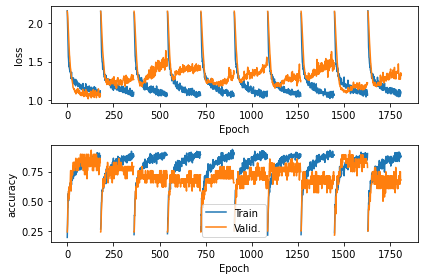

In [17]:
from indl.metrics import quickplot_history

history, accuracy = get_hists_acc(sess_id_old,new=False, verbose=2)
quickplot_history(history)

### Finding fixed points in lstm's recurrent cell states
#### Looking into saved best models for ten splits

In [31]:
# WARNING: Running the next cell may take several hours to finish on CPU
# You can jump to the "load pickle" cell (Four cells later) and the next one after that to plot the results

In [12]:
NCOMP = 2
fxpts = []


for i in range(N_SPLITS):
    print(f'Working on Split #{i}, new data')
    model = tf.keras.models.load_model(f'r2c_lstm_sra3_1_j_050_00+new_split{i}.h5')
    lstm = model.layers[10].get_weights()
    cell_states = lstm[1][:, model_kwargs['n_rnn'] * 2: model_kwargs['n_rnn'] * 3]
    W = cell_states * 10
    fxpt, _ = rfx.run_solver(W)
#     pca = PCA(n_components=NCOMP)
#     tmp = fxpt.T
#     fxpt_pc = pca.fit_transform(tmp)
#     fxpt_pc = fxpt_pc.T
    fxpts.append(fxpt)
    
    print(f'Working on Split #{i}, old data')
    model = tf.keras.models.load_model(f'r2c_lstm_sra3_1_j_050_00_v1+old_split{i}.h5')
    lstm = model.layers[10].get_weights()
    cell_states = lstm[1][:, model_kwargs['n_rnn'] * 2: model_kwargs['n_rnn'] * 3]
    W = cell_states * 10
    fxpt, _ = rfx.run_solver(W)
#     pca = PCA(n_components=NCOMP)
#     tmp = fxpt.T
#     fxpt_pc = pca.fit_transform(tmp)
#     fxpt_pc = fxpt_pc.T
    fxpts.append(fxpt)
    


Working on Split #0, new data
Working on Split #0, old data
Working on Split #1, new data
Working on Split #1, old data
Working on Split #2, new data
Working on Split #2, old data
Working on Split #3, new data
Working on Split #3, old data
Working on Split #4, new data
Working on Split #4, old data
Working on Split #5, new data
Working on Split #5, old data
Working on Split #6, new data
Working on Split #6, old data
Working on Split #7, new data
Working on Split #7, old data
Working on Split #8, new data
Working on Split #8, old data
Working on Split #9, new data
Working on Split #9, old data


In [13]:
with open('fixed_points.pkl', 'wb') as f:
    pickle.dump(fxpts, f)

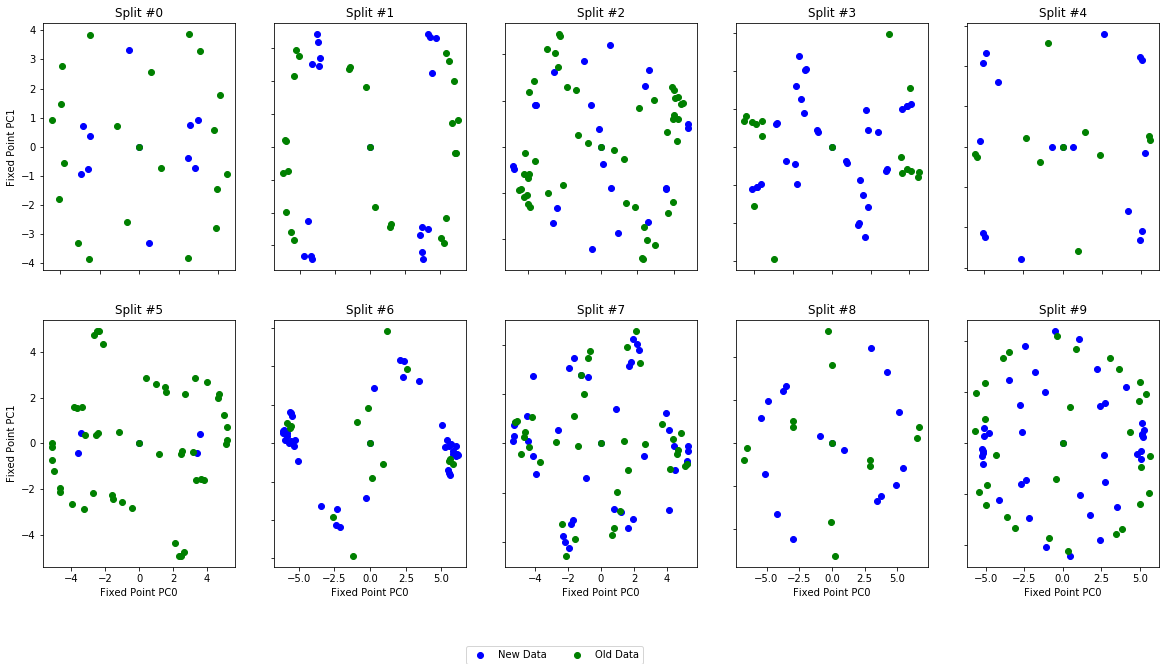

In [28]:
# fig, axs = plt.subplots(2, 5, figsize=(20, 10))
# for i in range(N_SPLITS):
#     axs[int(i/5), i%5].plot(fxpts[2*i][0], fxpts[2*i][1], 'bo')
#     axs[int(i/5), i%5].set_title(f'Split #{i}')
    
#     axs[int(i/5), i%5].plot(fxpts[2*i+1][0], fxpts[2*i+1][1], 'go')
    
# for ax in axs.flat:
#     ax.set(xlabel='Fixed Point PC0', ylabel='Fixed Point PC1')

# for ax in axs.flat:
#     ax.label_outer()
    
# fig.legend(["New Data", "Old Data"], loc = (0.4, 0), ncol=5 )

In [10]:
with open('fixed_points.pkl', 'rb') as f:
    fxpts_list = pickle.load(f)

In [53]:
print(len(fxpts_list), fxpts_list[0].shape)

20 (64, 19)


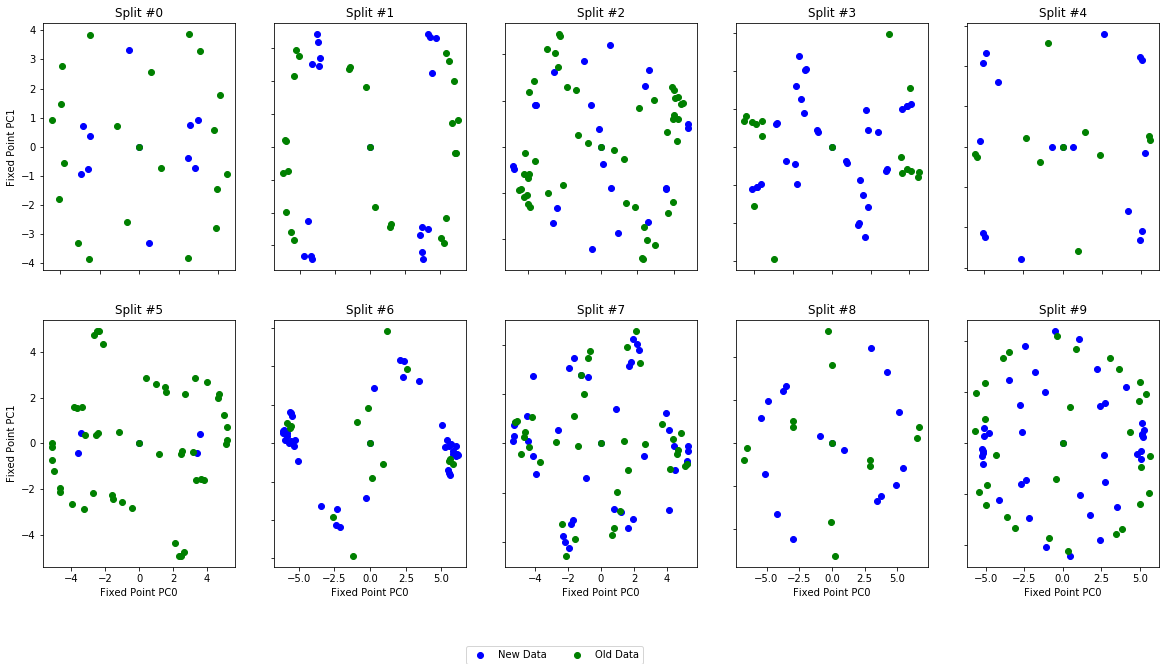

In [30]:
# fig, axs = plt.subplots(2, 5, figsize=(20, 10))
# for i in range(N_SPLITS):
#     axs[int(i/5), i%5].plot(fxpts_list[2*i][0], fxpts_list[2*i][1], 'bo')
#     axs[int(i/5), i%5].set_title(f'Split #{i}')
    
#     axs[int(i/5), i%5].plot(fxpts_list[2*i+1][0], fxpts_list[2*i+1][1], 'go')
    
# for ax in axs.flat:
#     ax.set(xlabel='Fixed Point PC0', ylabel='Fixed Point PC1')

# for ax in axs.flat:
#     ax.label_outer()
    
# fig.legend(["New Data", "Old Data"], loc = (0.4, 0), ncol=5 )

In [13]:
# model = tf.keras.models.load_model(f'r2c_lstm_sra3_1_j_050_00+new_split0.h5')
# lstm = model.layers[10].get_weights()
# output = model.layers[9].output
# factor_model = tf.keras.Model(model.input, output)
# factor_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 171)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 36, 171, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 147, 8)        208       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 147, 8)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 147, 8)         296       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 147, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 1, 147, 8)         0     

In [14]:
# factors = factor_model(X_rates)
# print(X_rates.shape, factors.shape)

(285, 36, 171) (285, 16, 8)


In [15]:
# inputs = tf.keras.layers.Input(shape=factors.shape[1:])
# state_lstm = tf.keras.layers.LSTM(model_kwargs['n_rnn'],
#                                   kernel_regularizer=tf.keras.regularizers.l2(model_kwargs['l2_reg']),
#                                   recurrent_regularizer=tf.keras.regularizers.l2(model_kwargs['l2_reg']),
#                                   return_sequences=True,
#                                   name='state_rnn1')(inputs)
# state_model = tf.keras.Model(inputs, state_lstm)

# state_model.layers[-1].set_weights(lstm)

# state_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 8)]           0         
_________________________________________________________________
state_rnn1 (LSTM)            (None, 16, 64)            18688     
Total params: 18,688
Trainable params: 18,688
Non-trainable params: 0
_________________________________________________________________


In [17]:
# state_outputs = state_model(factors)
# print(state_outputs.shape)
# print(state_outputs[0].shape, state_outputs[1].shape, state_outputs[2].shape)

(285, 16, 64)


In [19]:
# tmp = np.reshape(state_outputs, (state_outputs.shape[0] * state_outputs.shape[0], state_outputs.shape[2]))
# print(tmp.shape)

(4560, 64)


In [20]:
# pca = PCA(n_components=2)
# tmp = pca.fit_transform(tmp)
# print(tmp.shape)

(4560, 2)


In [23]:
# states_pc = np.reshape(tmp, (state_outputs.shape[0], state_outputs.shape[1], tmp.shape[1]))
# print(states_pc.shape)

(285, 16, 2)


In [27]:
# fxpts_list[0].shape

(64, 19)

### Looping over all splits for the new and old data

In [18]:
hidden_states = []
# fixed_points = []

for i in range(N_SPLITS):
#     print(f'Working on Split #{i}, new data')
#     model = tf.keras.models.load_model(f'r2c_lstm_sra3_1_j_050_00+_split{i}.h5')
#     lstm = model.layers[10].get_weights()
#     output = model.layers[9].output
#     factor_model = tf.keras.Model(model.input, output)
#     factors = factor_model(X_rates)
#     inputs = tf.keras.layers.Input(shape=factors.shape[1:])
#     state_lstm = tf.keras.layers.LSTM(model_kwargs['n_rnn'],
#                                       kernel_regularizer=tf.keras.regularizers.l2(model_kwargs['l2_reg']),
#                                       recurrent_regularizer=tf.keras.regularizers.l2(model_kwargs['l2_reg']),
#                                       return_sequences=True,
#                                       name='state_rnn1')(inputs)
#     state_model = tf.keras.Model(inputs, state_lstm)
#     state_model.layers[-1].set_weights(lstm)
#     state_outputs = state_model(factors)
    
#     pca = PCA(n_components=2)
#     tmp = np.reshape(state_outputs, (state_outputs.shape[0] * state_outputs.shape[1], state_outputs.shape[2]))
#     st_out_pc = pca.fit_transform(tmp)
#     tmp = np.reshape(st_out_pc, (state_outputs.shape[0], state_outputs.shape[1], st_out_pc.shape[1]))
#     hidden_states.append(tmp)
    
#     tmp = fxpts_list[2*i].T
#     tmp = pca.transform(tmp)
#     fixed_points.append(tmp.T)
    
    print(f'Working on Split #{i}, old data')
    model = tf.keras.models.load_model(f'r2c_lstm_sra3_1_j_050_00_v1+old_split{i}.h5')
    lstm = model.layers[10].get_weights()
    output = model.layers[9].output
    factor_model = tf.keras.Model(model.input, output)
    factors = factor_model(X_rates_old)
    inputs = tf.keras.layers.Input(shape=factors.shape[1:])
    state_lstm = tf.keras.layers.LSTM(model_kwargs['n_rnn'],
                                      kernel_regularizer=tf.keras.regularizers.l2(model_kwargs['l2_reg']),
                                      recurrent_regularizer=tf.keras.regularizers.l2(model_kwargs['l2_reg']),
                                      return_sequences=True,
                                      name='state_rnn1')(inputs)
    state_model = tf.keras.Model(inputs, state_lstm)

    state_model.layers[-1].set_weights(lstm)
    state_outputs = state_model(factors)
    
    pca = PCA(n_components=2)
    tmp = np.reshape(state_outputs, (state_outputs.shape[0] * state_outputs.shape[1], state_outputs.shape[2]))
    st_out_pc = pca.fit_transform(tmp)
    tmp = np.reshape(st_out_pc, (state_outputs.shape[0], state_outputs.shape[1], st_out_pc.shape[1]))
    hidden_states.append(tmp)
    
#     tmp = fxpts_list[2*i+1].T
#     tmp = pca.transform(tmp)
#     fixed_points.append(tmp.T)

Working on Split #0, old data
Working on Split #1, old data
Working on Split #2, old data
Working on Split #3, old data
Working on Split #4, old data
Working on Split #5, old data
Working on Split #6, old data
Working on Split #7, old data
Working on Split #8, old data
Working on Split #9, old data


In [8]:
print(len(hidden_states), hidden_states[0].shape)#, len(fixed_points), fixed_points[0].shape)

10 (483, 33, 2)


In [59]:
# hidden_states_norm = hidden_states
# fxpts_list_norm = fxpts_list
# for i in range(2*N_SPLITS):
#     hidden_states_norm[i] =  2 * ((hidden_states_norm[i] - np.min(hidden_states_norm[i]))/(np.max(hidden_states_norm[i]) - np.min(hidden_states_norm[i]))) - 1
#     fxpts_list_norm[i] =  2 * ((fxpts_list_norm[i] - np.min(fxpts_list_norm[i]))/(np.max(fxpts_list_norm[i]) - np.min(fxpts_list_norm[i]))) - 1

In [9]:
color_map = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink', 'tab:olive', 'tab:cyan', 'tab:purple']
int(Y_new[100])

4

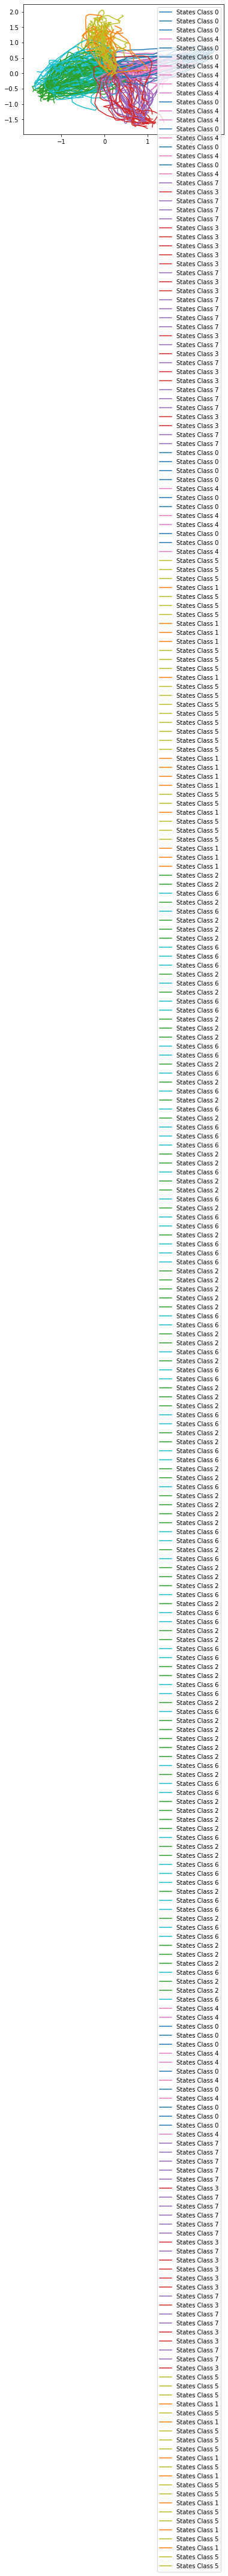

In [66]:
# for j in range(285):
#     lbl = f'States Class {int(Y_new[j])}'
#     plt.plot(hidden_states[0][j, :, 0], hidden_states[0][j, :, 1], color_map[int(Y_new[j])], label=lbl)
    
# plt.legend()

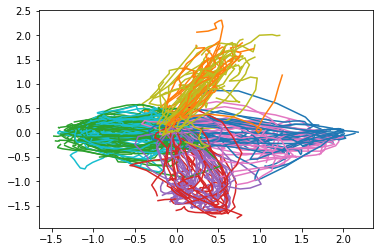

In [20]:
for j in range(285):
    plt.plot(hidden_states[0][j, :, 0], hidden_states[0][j, :, 1], color_map[int(Y_old[j])])

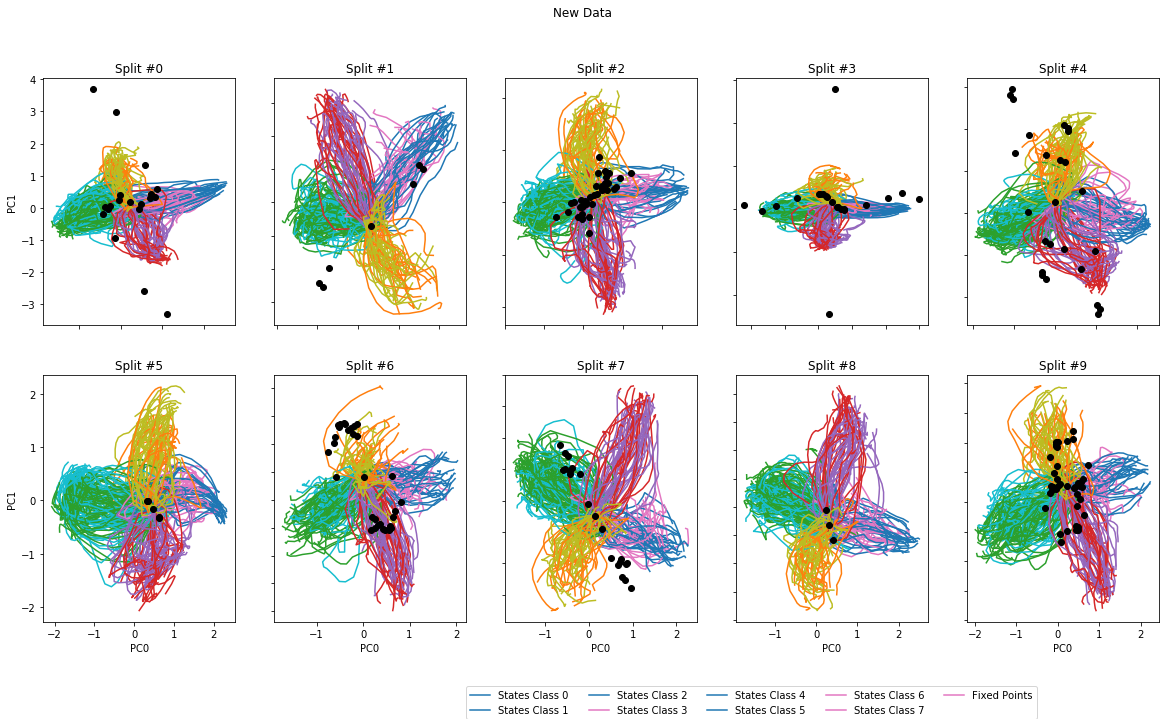

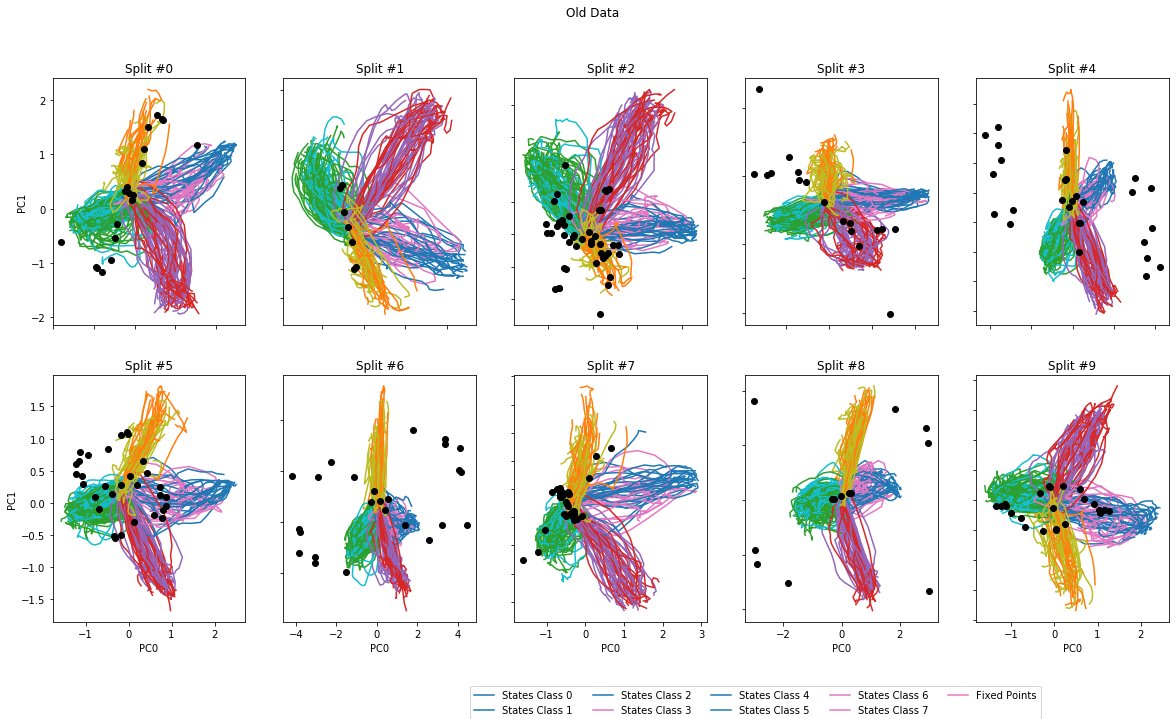

In [63]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle("New Data")
for i in range(N_SPLITS):
    for j in range(X_rates.shape[0]):
        axs[int(i/5), i%5].plot(hidden_states[2*i][j, :, 0], hidden_states[2*i][j, :, 1], color_map[int(Y_new[j])])
    axs[int(i/5), i%5].set_title(f'Split #{i}')
    
    axs[int(i/5), i%5].plot(fixed_points[2*i][0], fixed_points[2*i][1], 'ko')
    
for ax in axs.flat:
    ax.set(xlabel='PC0', ylabel='PC1')

for ax in axs.flat:
    ax.label_outer()
    
fig.legend(["States Class 0", "States Class 1", "States Class 2", "States Class 3", "States Class 4", "States Class 5",
            "States Class 6", "States Class 7", "Fixed Points"], loc = (0.4, 0), ncol=5 )


fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle("Old Data")
for i in range(N_SPLITS):
    for j in range(X_rates_old.shape[0]):
        axs[int(i/5), i%5].plot(hidden_states[2*i+1][j, :, 0], hidden_states[2*i+1][j, :, 1], color_map[int(Y_old[j])])
    axs[int(i/5), i%5].set_title(f'Split #{i}')
    
    axs[int(i/5), i%5].plot(fixed_points[2*i+1][0], fixed_points[2*i+1][1], 'ko')
    
for ax in axs.flat:
    ax.set(xlabel='PC0', ylabel='PC1')

for ax in axs.flat:
    ax.label_outer()
    
fig.legend(["States Class 0", "States Class 1", "States Class 2", "States Class 3", "States Class 4", "States Class 5",
            "States Class 6", "States Class 7", "Fixed Points"], loc = (0.4, 0), ncol=5 )

# Training a Rule Model

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from scipy import signal
from scipy import stats
from sklearn.model_selection import train_test_split
from indl.fileio import from_neuropype_h5
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from itertools import cycle

import os

if Path.cwd().stem == 'Analysis':
    os.chdir(Path.cwd().parent.parent)
    
    
data_path = Path.cwd() / 'StudyLocationRule'/ 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")
    
from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc

load_kwargs = {
    'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': False,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
load_kwargs_ul = {
    'valid_outcomes': (9,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': False,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
load_kwargs_all = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': False,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
## Model Parameters
BATCH_SIZE = 16
EPOCHS = 150
LABEL_SMOOTHING = 0.2

model_kwargs = dict(
    filt=8,
    kernLength=25,
    ds_rate=9,
    n_rnn=64,
    n_rnn2=0,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0001, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)

from indl.model import parts
from indl.regularizers import KernelLengthRegularizer

def make_model(
    _input,
    num_classes,
    filt=8,
    kernLength=25,
    ds_rate=10,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.25,
    activation='relu',
    l1_reg=0.000, l2_reg=0.000,
    norm_rate=0.25,
    latent_dim=16,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
    if _input.shape[2] < 10:
        kernLength = 4
        filt = 4
        ds_rate = 4
    elif _input.shape[2] < 20:
        kernLength = 8
        ds_rate = 8
    elif _input.shape[2] < 30:
        kernLength = 16
    
    input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
    if len(input_shape) < 4:
        input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv2D(filt, (1, kernLength), padding='valid', data_format=None,
                                dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
                                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.DepthwiseConv2D((_y.shape.as_list()[1], 1), padding='valid',
                                      depth_multiplier=1, data_format=None, dilation_rate=(1, 1),
                                      activation=None, use_bias=True, depthwise_initializer='glorot_uniform',
                                      bias_initializer='zeros', depthwise_regularizer=None,
                                      bias_regularizer=None, activity_regularizer=None,
                                      depthwise_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.AveragePooling2D(pool_size=(1, ds_rate))(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.Reshape(_y.shape.as_list()[2:])(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = tf.keras.layers.Dense(latent_dim, activation=activation)(_y)
#     _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(_y)
#     outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

Data directory found. Skipping download.


In [2]:
test_sess_ix = 0
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spiketrains', **load_kwargs)
print(X_rates.shape, Y.shape)


Importing session sra3_2_j_037_00+03
(223, 12, 2718) (223, 1)


In [3]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
classes, _y = np.unique(Y_class, return_inverse=True)
# Y_class = tf.keras.utils.to_categorical(Y_class, num_classes=8)


Importing session sra3_1_j_050_00+


In [7]:
_y.ravel()

array([0, 0, 4, 4, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4,
       4, 0, 4, 4, 0, 0, 4, 0, 4, 0, 4, 0, 4, 4, 0, 4, 0, 0, 0, 3, 7, 3,
       3, 7, 3, 7, 7, 3, 7, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3, 7, 7, 7, 3, 7,
       3, 7, 3, 3, 7, 7, 7, 3, 3, 7, 3, 7, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       4, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 1, 5, 5, 5, 1, 5, 1, 5, 1,
       1, 1, 5, 1, 5, 5, 5, 1, 1, 5, 1, 1, 1, 1, 1, 1, 5, 5, 5, 1, 1, 1,
       1, 5, 1, 5, 1, 1, 1, 5, 1, 5, 1, 5, 5, 5, 5, 1, 5, 1, 5, 5, 5, 1,
       5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 1, 5, 1, 1, 5, 5, 1, 1, 1, 1,
       1, 1, 1, 1, 6, 2, 6, 2, 2, 2, 2, 2, 6, 6, 6, 2, 6, 2, 2, 6, 6, 2,
       2, 2, 6, 6, 6, 2, 6, 2, 6, 2, 6, 2, 6, 6, 6, 2, 2, 6, 2, 2, 6, 2,
       6, 6, 2, 6, 2, 2, 6, 2, 2, 2, 6, 2, 6, 2, 2, 6, 2, 6, 6, 2, 2, 2,
       6, 6, 2, 2, 6, 6, 2, 2, 6, 2, 2, 2, 2, 6, 6, 2, 6, 2, 2, 2, 6, 2,
       6, 6, 2, 2, 6, 6, 2, 2, 6, 6, 2, 6, 2, 2, 2, 2, 2, 2, 6, 2, 6, 6,
       2, 2, 2, 2, 6, 6, 2, 2, 2, 2, 6, 6, 2, 2, 2,

In [5]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7])

In [6]:
Y_class

array([[0],
       [0],
       [4],
       [4],
       [0],
       [0],
       [0],
       [4],
       [4],
       [0],
       [0],
       [4],
       [0],
       [0],
       [0],
       [0],
       [0],
       [4],
       [4],
       [0],
       [0],
       [4],
       [4],
       [0],
       [4],
       [4],
       [0],
       [0],
       [4],
       [0],
       [4],
       [0],
       [4],
       [0],
       [4],
       [4],
       [0],
       [4],
       [0],
       [0],
       [0],
       [3],
       [7],
       [3],
       [3],
       [7],
       [3],
       [7],
       [7],
       [3],
       [7],
       [3],
       [3],
       [3],
       [3],
       [3],
       [7],
       [3],
       [3],
       [7],
       [3],
       [7],
       [7],
       [7],
       [3],
       [7],
       [3],
       [7],
       [3],
       [3],
       [7],
       [7],
       [7],
       [3],
       [3],
       [7],
       [3],
       [7],
       [4],
       [0],
       [0],
       [0],
       [0],
    

In [22]:
ax_info

{'instance_data':       Marker ExperimentType NewType CueColour TargetRule TargetStr  \
 75    Target              C     SR3         b         UU        UU   
 79    Target              C     SR3         b         UU        UU   
 80    Target              C     SR3         g         DD        DD   
 82    Target              C     SR3         g         DD        DD   
 86    Target              C     SR3         b         UU        UU   
 ...      ...            ...     ...       ...        ...       ...   
 1262  Target              C     SR3         b         DL        DL   
 1264  Target              C     SR3         r         UR        UR   
 1265  Target              C     SR3         r         UR        UR   
 1267  Target              C     SR3         b         DL        DL   
 1269  Target              C     SR3         b         DL        DL   
 
      DistractorStr  TargetValue  IsGood  EyelinkTime  ...  NEVTimestamps  \
 75              DD          NaN    True  2627.55826

In [48]:
target = np.array(ax_info['instance_data']['TargetRule'])
color = np.array(ax_info['instance_data']['CueColour'])
trial = np.array(ax_info['instance_data']['TrialIndex'])

In [49]:
label = np.zeros(len(target))
for i in range(len(label)):
    if (target[i]=='DD' and color[i]=='g'):
        label[i] = 12
    elif (target[i]=='UU' and color[i]=='b'):
        label[i] = 1
    elif (target[i]=='DR' and color[i]=='r'):
        label[i] = 2
    elif (target[i]=='UL' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='DL' and color[i]=='b'):
        label[i] = 4
    elif (target[i]=='UR' and color[i]=='g'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='r'):
        label[i] = 6
    elif (target[i]=='RR' and color[i]=='g'):
        label[i] = 7
    elif (target[i]=='UU' and color[i]=='r'):
        label[i] = 8
    elif (target[i]=='DR' and color[i]=='g'):
        label[i] = 9
    elif (target[i]=='DL' and color[i]=='r'):
        label[i] = 10
    elif (target[i]=='UR' and color[i]=='r'):
        label[i] = 11
        
keep_idx = np.argwhere(label>0).flatten()

new_label = label[keep_idx].flatten().astype(int)
new_X = X_rates[keep_idx]
new_Y = Y[keep_idx].flatten()
new_target = target[keep_idx]
new_color = color[keep_idx]
new_trial = trial[keep_idx]

zer_idx = np.argwhere(new_label==12).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_Y.shape, new_target.shape, new_color.shape, new_trial.shape)

(483, 36, 2050) (483,) (483,) (483,) (483,) (483,)


In [105]:
spikes = np.zeros((np.size(new_X,0), np.size(new_X,1), np.size(new_X,2)//5 + 1))
for tr in range(np.size(new_X,0)):
    for ch in range(np.size(new_X,1)):
        spk_idx = np.argwhere(new_X[tr,ch,:]==1).flatten()
        spk_idx = spk_idx // 5
        spikes[tr,ch,spk_idx] = 1

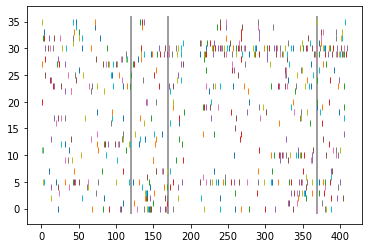

In [106]:
for ch in range(np.size(spikes,1)):
    for t in range(np.size(spikes,2)):
        if spikes[0,ch,t]==1:
            plt.plot(t, ch, '|')
plt.vlines(120,-1,36,'grey')
plt.vlines(170, -1, 36, 'grey')
plt.vlines(370, -1, 36, 'grey')
plt.show()

In [107]:
Y_class = tf.keras.utils.to_categorical(new_Y, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((spikes, Y_class))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)

ds_train = ds_train.shuffle(len(new_Y) + 1)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(
    spikes,
    Y_class.shape[-1],
    **model_kwargs
)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])


hist = model.fit(x=ds_train, epochs=EPOCHS, verbose=1)

Epoch 1/150
30/30 [==============================] - 2s 53ms/step - loss: 2.1502 - accuracy: 0.2083
Epoch 2/150
30/30 [==============================] - 2s 54ms/step - loss: 1.8485 - accuracy: 0.4000
Epoch 3/150
30/30 [==============================] - 2s 54ms/step - loss: 1.6714 - accuracy: 0.4729
Epoch 4/150
30/30 [==============================] - 2s 54ms/step - loss: 1.5904 - accuracy: 0.5875
Epoch 5/150
30/30 [==============================] - 2s 54ms/step - loss: 1.4698 - accuracy: 0.6417
Epoch 6/150
30/30 [==============================] - 2s 54ms/step - loss: 1.4668 - accuracy: 0.6479
Epoch 7/150
30/30 [==============================] - 2s 54ms/step - loss: 1.4373 - accuracy: 0.6521
Epoch 8/150
30/30 [==============================] - 2s 54ms/step - loss: 1.4139 - accuracy: 0.6646
Epoch 9/150
30/30 [==============================] - 2s 54ms/step - loss: 1.4085 - accuracy: 0.6521
Epoch 10/150
30/30 [==============================] - 2s 54ms/step - loss: 1.3658 - accuracy: 0.6854

In [63]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 411)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 36, 411, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 387, 8)        208       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 387, 8)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 387, 8)         296       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 387, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 1, 387, 8)        

In [108]:
lstm = model.layers[10].get_weights()
output = model.layers[9].output
factor_model = tf.keras.Model(model.input, output)
factors = factor_model(spikes)
inputs = tf.keras.layers.Input(shape=factors.shape[1:])
state_lstm = tf.keras.layers.LSTM(model_kwargs['n_rnn'],
                                  kernel_regularizer=tf.keras.regularizers.l2(model_kwargs['l2_reg']),
                                  recurrent_regularizer=tf.keras.regularizers.l2(model_kwargs['l2_reg']),
                                  return_sequences=True,
                                  name='state_rnn1')(inputs)
state_model = tf.keras.Model(inputs, state_lstm)
state_model.layers[-1].set_weights(lstm)
state_outputs = state_model(factors)

In [65]:
print(np.array(state_outputs).shape,np.array(factors).shape)

(483, 43, 64)

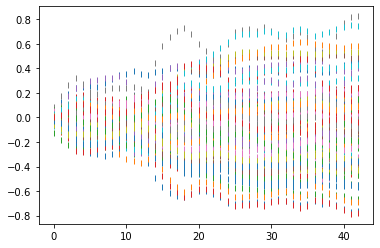

In [109]:
plt.plot(state_outputs[0],'|')
plt.show()

In [ ]:
plt.plot(factors[0],'|')
plt.show()

In [110]:
pca = PCA(n_components=32)
tmp = np.reshape(state_outputs, (state_outputs.shape[0] * state_outputs.shape[1], state_outputs.shape[2]))
pca_values = pca.fit_transform(tmp)
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_values = tsne_model.fit_transform(pca_values)
hidden_states = np.reshape(tsne_values, (state_outputs.shape[0], state_outputs.shape[1], tsne_values.shape[1]))

In [68]:
print(hidden_states.shape)

(483, 43, 2)


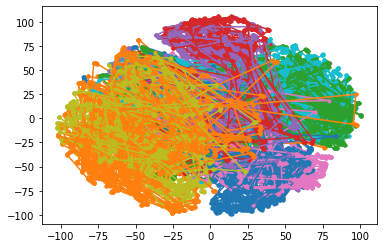

In [111]:
color_map = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink', 'tab:olive', 'tab:cyan', 'tab:purple']
for tr in range(np.size(hidden_states,0)):
    plt.plot(hidden_states[tr,:,0], hidden_states[tr,:,1], '.-', color=color_map[new_Y[tr]])
plt.show()

In [39]:
max(new_Y)

7

In [71]:
lstm = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[10].output)(new_X)
print(lstm.shape)

(520, 299, 32)


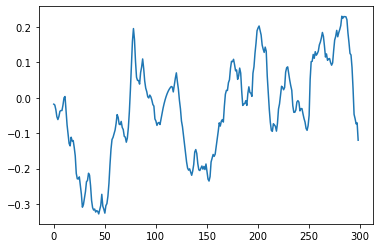

In [74]:
plt.plot(lstm[100,:,1])

In [76]:
lstm = np.array(lstm)

In [77]:
from scipy.io import savemat
data = {'lstm': lstm,
        'label': label,
        'spikes': new_X,
        'y': new_Y,
        'trial': new_trial,
        'target': new_target,
        'color': new_color}
name = 'lstm_output.mat'
savemat(name, data)

In [94]:
from scipy.io import savemat

for test_sess_ix in range(8):
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"\nImporting session {sess_id}")
    X, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spiketrains', **load_kwargs)
    target = np.array(ax_info['instance_data']['TargetRule'])
    color = np.array(ax_info['instance_data']['CueColour'])
    trial = np.array(ax_info['instance_data']['TrialIndex'])
    targets = np.zeros(len(target))
    for i in range(len(targets)):
        if (target[i]=='UU'):
            targets[i] = 0
        elif (target[i]=='UR'):
            targets[i] = 1
        elif (target[i]=='RR'):
            targets[i] = 2
        elif (target[i]=='DR'):
            targets[i] = 3
        elif (target[i]=='DD'):
            targets[i] = 4
        elif (target[i]=='DL'):
            targets[i] = 5
        elif (target[i]=='LL'):
            targets[i] = 6
        elif (target[i]=='UL'):
            targets[i] = 7
    spikes = np.zeros((np.size(X,0), np.size(X,1), np.size(X,2)//5 + 1))
    for tr in range(np.size(X,0)):
        for ch in range(np.size(X,1)):
            spk_idx = np.argwhere(X[tr,ch,:]==1).flatten()
            spk_idx = spk_idx // 5
            spikes[tr,ch,spk_idx] = 1
    data = {'spikes': spikes,
            'saccades': Y,
            'targets': targets,
            'colors': color,
           'trial': trial}
    name = f'{sess_id.replace("+", "")}_cor.mat'
    savemat(name, data)


Importing session sra3_2_j_037_00+03

Importing session sra3_1_j_050_00+

Importing session sra3_1_j_051_00+

Importing session sra3_1_j_052_00+

Importing session sra3_1_m_077_00+01

Importing session sra3_1_m_081_00+01

Importing session sra3_1_m_082_00+01

Importing session sra3_1_m_083_00+01


In [96]:
sess_infos

[{'name': 'JerryLee',
  'bank': 'A',
  'name_short': 'j',
  'date': '090601',
  'exp_code': 'sra3_2_j_037_00+03',
  'nsx': 'datafile003.ns2'},
 {'name': 'JerryLee',
  'bank': 'A',
  'name_short': 'j',
  'date': '090623',
  'exp_code': 'sra3_1_j_050_00+',
  'nsx': 'datafile002.ns2'},
 {'name': 'JerryLee',
  'bank': 'B',
  'name_short': 'j',
  'date': '090624',
  'exp_code': 'sra3_1_j_051_00+',
  'nsx': 'datafile002.ns2'},
 {'name': 'JerryLee',
  'bank': 'C',
  'name_short': 'j',
  'date': '090625',
  'exp_code': 'sra3_1_j_052_00+',
  'nsx': 'datafile003.ns2'},
 {'name': 'Marty',
  'bank': 'C',
  'name_short': 'm',
  'date': '090919',
  'exp_code': 'sra3_1_m_077_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Marty',
  'bank': 'B',
  'name_short': 'm',
  'date': '090925',
  'exp_code': 'sra3_1_m_081_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Marty',
  'bank': 'A',
  'name_short': 'm',
  'date': '090926',
  'exp_code': 'sra3_1_m_082_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Mar

## Manual Loading

In [1]:
import tensorflow as tf

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [2]:
import indl

In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from scipy import signal
from scipy import stats
from sklearn.model_selection import train_test_split
from indl.fileio import from_neuropype_h5
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import FactorAnalysis
from itertools import cycle

import os

if Path.cwd().stem == 'Analysis':
    os.chdir(Path.cwd().parent.parent)
    
    
data_path = Path.cwd() / 'StudyLocationRule'/ 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")
    
from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc

load_kwargs = {
    'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_error = {
    'valid_outcomes': (9,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_all = {
    'valid_outcomes': (0,9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

model_kwargs = dict(
    filt=8,
    kernLength=20,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=0,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)
model_kwargs1 = dict(
    filt=16,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)
model_kwargs2 = dict(
    filt=32,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)

N_SPLITS = 10
BATCH_SIZE = 16
EPOCHS = 150
EPOCHS2 = 100
LABEL_SMOOTHING = 0.2

Data directory found. Skipping download.


In [5]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [7]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [4]:
test_sess_ix = 4
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_077_0001_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = np.array(segmented_data[2][1]['axes'][0]['data']['OutcomeCode'])
flag = np.argwhere(outcome>-1).flatten()
outcome = outcome[flag]
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data'][flag]
X = np.nan_to_num(X)
X = np.transpose(X, (0, 2, 1))
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()[flag]
b=np.diff(block, axis=0)
border=np.array(np.where(b>0)).flatten()
to_keep = [0]
for i in range(len(border)-2):
    if (border[i+1] - border[i]) > 30:
        to_keep.append(i+1)
if (len(outcome)-border[-1] > 30):
    to_keep.append(-1)
border = border[to_keep]
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()[flag]
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()[flag]
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()[flag]

print(border)
print(sess_id)
print(outcome.shape)
print(X.shape, Y.shape, np.unique(Y, return_counts=True))

[ 178  425 1236 1314 1382]
sra3_1_m_077_00+01
(1456,)
(1456, 18, 2483) (1456,) (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([425,  31, 112, 161, 386,  37, 140, 164], dtype=int64))


In [5]:
rule = np.zeros(np.size(X,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)

In [8]:
np.unique(rule, return_counts=True)

(array([ 1,  3,  6,  9, 11, 12, 16, 19, 20, 22]),
 array([425,  31, 112, 118,  43, 386,  37,  97,  43, 164]))

In [6]:
rules = np.zeros(len(rule))
unique = np.unique(rule)
for i in range(len(rules)):
    for j in range(len(unique)):
        if rule[i] == unique[j]:
            rules[i] = j
rules = rules.astype(int)
np.unique(rules, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([425,  31, 112, 118,  43, 386,  37,  97,  43, 164], dtype=int64))

1140 117


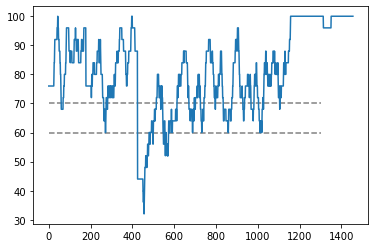

In [7]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

plt.plot(m_performance)
plt.hlines(70,-1,1300,'grey','dashed')
plt.hlines(60,-1,1300,'grey','dashed')
learned = np.argwhere(m_performance>69).flatten()
unlearned = np.argwhere(m_performance<61).flatten()
print(len(learned),len(unlearned))

In [8]:
def make_model(
    _input,
    num_classes,
    filt=8,
    kernLength=25,
    ds_rate=10,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.25,
    activation='relu',
    l1_reg=0.000, l2_reg=0.000,
    norm_rate=0.25,
    latent_dim=16,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
    if _input.shape[2] < 10:
        kernLength = 4
        filt = 4
        ds_rate = 4
    elif _input.shape[2] < 20:
        kernLength = 8
        ds_rate = 8
    elif _input.shape[2] < 30:
        kernLength = 16
    
    input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
    if len(input_shape) < 4:
        input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv2D(filt, (1, kernLength), padding='valid', data_format=None,
                                dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
                                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.DepthwiseConv2D((_y.shape.as_list()[1], 1), padding='valid',
                                      depth_multiplier=1, data_format=None, dilation_rate=(1, 1),
                                      activation=None, use_bias=True, depthwise_initializer='glorot_uniform',
                                      bias_initializer='zeros', depthwise_regularizer=None,
                                      bias_regularizer=None, activity_regularizer=None,
                                      depthwise_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.AveragePooling2D(pool_size=(1, ds_rate))(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.Reshape(_y.shape.as_list()[2:])(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = tf.keras.layers.Dense(latent_dim, activation=activation)(_y)
#     _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(_y)
#     outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

def make_model2(
    _input,
    num_classes,
    filt=32,
    kernLength=16,
    n_rnn=32,
    n_rnn2=0,
    dropoutRate=0.1,
    activation='tanh',
    l1_reg=0.010, l2_reg=0.010,
    norm_rate=0.25,
    latent_dim=32,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
#     if _input.shape[2] < 10:
#         kernLength = 4
#         filt = 4
#         ds_rate = 4
#     elif _input.shape[2] < 20:
#         kernLength = 8
#         ds_rate = 8
#     elif _input.shape[2] < 30:
#         kernLength = 16
    
#     input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
#     if len(input_shape) < 4:
#         input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
#     _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv1D(filt, kernLength, strides=1, padding='valid',
                                data_format='channels_last', dilation_rate=1, groups=1,
                                activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None,
                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
                                bias_constraint=None)(inputs)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = tf.keras.layers.Dense(latent_dim, activation=activation)(_y)
#     _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(_y)
#     outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)


def kfold_pred(sess_id,X_rates,Y_class,name, verbose=1):
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=np.max(Y_class)+1)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model2(X_rates, _y.shape[-1])
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'{name}_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")
    
    return history, accuracy, pred_y, true_y

In [22]:
X[learned].shape

(1140, 18, 2483)

In [40]:
np.unique(rules, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([425,  31, 112, 118,  43, 386,  37,  97,  43, 164]))

In [9]:
_X = np.transpose(X,(0,2,1))
model = make_model2(_X,10)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2483, 18)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2468, 32)          9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 2468, 32)          128       
_________________________________________________________________
dropout (Dropout)            (None, 2468, 32)          0         
_________________________________________________________________
rnn1 (LSTM)                  (None, 32)                8320      
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)               

In [41]:
N_SPLITS = 10
hist, acc, y_pred, y_true = kfold_pred(sess_id,_X,rules,name='rd_all' ,verbose=1)

	Split 1 of 10
Epoch 1/150
81/81 [==============================] - 7s 69ms/step - loss: 3.2275 - accuracy: 0.1288 - val_loss: 2.7473 - val_accuracy: 0.2808

Epoch 00001: val_accuracy improved from -inf to 0.28082, saving model to rd_all_sra3_1_m_077_00+01_split0.h5
Epoch 2/150
81/81 [==============================] - 4s 50ms/step - loss: 2.6918 - accuracy: 0.3022 - val_loss: 2.5287 - val_accuracy: 0.3288

Epoch 00002: val_accuracy improved from 0.28082 to 0.32877, saving model to rd_all_sra3_1_m_077_00+01_split0.h5
Epoch 3/150
81/81 [==============================] - 4s 52ms/step - loss: 2.4210 - accuracy: 0.3599 - val_loss: 2.4261 - val_accuracy: 0.3082

Epoch 00003: val_accuracy did not improve from 0.32877
Epoch 4/150
81/81 [==============================] - 4s 50ms/step - loss: 2.2663 - accuracy: 0.3871 - val_loss: 2.3845 - val_accuracy: 0.3151

Epoch 00004: val_accuracy did not improve from 0.32877
Epoch 5/150
81/81 [==============================] - 4s 50ms/step - loss: 2.1784 -


Epoch 00041: val_accuracy did not improve from 0.32877
Epoch 42/150
81/81 [==============================] - 4s 50ms/step - loss: 1.6117 - accuracy: 0.6793 - val_loss: 2.4623 - val_accuracy: 0.3014

Epoch 00042: val_accuracy did not improve from 0.32877
Epoch 43/150
81/81 [==============================] - 4s 50ms/step - loss: 1.5503 - accuracy: 0.7125 - val_loss: 2.4483 - val_accuracy: 0.2945

Epoch 00043: val_accuracy did not improve from 0.32877
Epoch 44/150
81/81 [==============================] - 4s 50ms/step - loss: 1.5765 - accuracy: 0.6883 - val_loss: 2.4273 - val_accuracy: 0.3082

Epoch 00044: val_accuracy did not improve from 0.32877
Epoch 45/150
81/81 [==============================] - 4s 50ms/step - loss: 1.5510 - accuracy: 0.6969 - val_loss: 2.4971 - val_accuracy: 0.3014

Epoch 00045: val_accuracy did not improve from 0.32877
Epoch 46/150
81/81 [==============================] - 4s 50ms/step - loss: 1.5784 - accuracy: 0.7158 - val_loss: 2.4764 - val_accuracy: 0.2877

Epoc

81/81 [==============================] - 4s 50ms/step - loss: 1.4151 - accuracy: 0.7732 - val_loss: 2.5839 - val_accuracy: 0.2740

Epoch 00083: val_accuracy did not improve from 0.32877
Epoch 84/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4200 - accuracy: 0.7926 - val_loss: 2.4742 - val_accuracy: 0.3219

Epoch 00084: val_accuracy did not improve from 0.32877
Epoch 85/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3970 - accuracy: 0.8153 - val_loss: 2.5256 - val_accuracy: 0.2877

Epoch 00085: val_accuracy did not improve from 0.32877
Epoch 86/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3923 - accuracy: 0.7968 - val_loss: 2.5496 - val_accuracy: 0.2740

Epoch 00086: val_accuracy did not improve from 0.32877
Epoch 87/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3972 - accuracy: 0.7985 - val_loss: 2.5514 - val_accuracy: 0.2603

Epoch 00087: val_accuracy did not improve from 0.32877
Epoch 88/150
81/81

81/81 [==============================] - 4s 50ms/step - loss: 1.2921 - accuracy: 0.8534 - val_loss: 2.6576 - val_accuracy: 0.2329

Epoch 00124: val_accuracy did not improve from 0.33562
Epoch 125/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3360 - accuracy: 0.8400 - val_loss: 2.5700 - val_accuracy: 0.2945

Epoch 00125: val_accuracy did not improve from 0.33562
Epoch 126/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3207 - accuracy: 0.8445 - val_loss: 2.6370 - val_accuracy: 0.2808

Epoch 00126: val_accuracy did not improve from 0.33562
Epoch 127/150
81/81 [==============================] - 4s 51ms/step - loss: 1.3312 - accuracy: 0.8227 - val_loss: 2.5586 - val_accuracy: 0.2877

Epoch 00127: val_accuracy did not improve from 0.33562
Epoch 128/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3439 - accuracy: 0.8154 - val_loss: 2.6676 - val_accuracy: 0.2740

Epoch 00128: val_accuracy did not improve from 0.33562
Epoch 129/150


81/81 [==============================] - 4s 49ms/step - loss: 1.8606 - accuracy: 0.5117 - val_loss: 2.2602 - val_accuracy: 0.2808

Epoch 00014: val_accuracy did not improve from 0.34247
Epoch 15/150
81/81 [==============================] - 4s 49ms/step - loss: 1.8278 - accuracy: 0.5277 - val_loss: 2.2212 - val_accuracy: 0.2877

Epoch 00015: val_accuracy did not improve from 0.34247
Epoch 16/150
81/81 [==============================] - 4s 49ms/step - loss: 1.7475 - accuracy: 0.5837 - val_loss: 2.2599 - val_accuracy: 0.2808

Epoch 00016: val_accuracy did not improve from 0.34247
Epoch 17/150
81/81 [==============================] - 4s 49ms/step - loss: 1.8311 - accuracy: 0.5197 - val_loss: 2.2545 - val_accuracy: 0.2945

Epoch 00017: val_accuracy did not improve from 0.34247
Epoch 18/150
81/81 [==============================] - 4s 49ms/step - loss: 1.7715 - accuracy: 0.5601 - val_loss: 2.2620 - val_accuracy: 0.2671

Epoch 00018: val_accuracy did not improve from 0.34247
Epoch 19/150
81/81

81/81 [==============================] - 4s 51ms/step - loss: 1.4867 - accuracy: 0.7259 - val_loss: 2.7311 - val_accuracy: 0.2192

Epoch 00096: val_accuracy did not improve from 0.35616
Epoch 97/150
81/81 [==============================] - 4s 49ms/step - loss: 1.4289 - accuracy: 0.7806 - val_loss: 2.6714 - val_accuracy: 0.2260

Epoch 00097: val_accuracy did not improve from 0.35616
Epoch 98/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4338 - accuracy: 0.7672 - val_loss: 2.6607 - val_accuracy: 0.2466

Epoch 00098: val_accuracy did not improve from 0.35616
Epoch 99/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4202 - accuracy: 0.7855 - val_loss: 2.6474 - val_accuracy: 0.2603

Epoch 00099: val_accuracy did not improve from 0.35616
Epoch 100/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3980 - accuracy: 0.7964 - val_loss: 2.7326 - val_accuracy: 0.2603

Epoch 00100: val_accuracy did not improve from 0.35616
Epoch 101/150
81/

81/81 [==============================] - 4s 50ms/step - loss: 1.3207 - accuracy: 0.8365 - val_loss: 2.7518 - val_accuracy: 0.2466

Epoch 00137: val_accuracy did not improve from 0.35616
Epoch 138/150
81/81 [==============================] - 4s 50ms/step - loss: 1.2815 - accuracy: 0.8634 - val_loss: 2.6859 - val_accuracy: 0.2534

Epoch 00138: val_accuracy did not improve from 0.35616
Epoch 139/150
81/81 [==============================] - 4s 50ms/step - loss: 1.2870 - accuracy: 0.8582 - val_loss: 2.7706 - val_accuracy: 0.2055

Epoch 00139: val_accuracy did not improve from 0.35616
Epoch 140/150
81/81 [==============================] - 4s 50ms/step - loss: 1.2751 - accuracy: 0.8597 - val_loss: 2.7154 - val_accuracy: 0.2192

Epoch 00140: val_accuracy did not improve from 0.35616
Epoch 141/150
81/81 [==============================] - 4s 51ms/step - loss: 1.2864 - accuracy: 0.8668 - val_loss: 2.7292 - val_accuracy: 0.2466

Epoch 00141: val_accuracy did not improve from 0.35616
Epoch 142/150



Epoch 00027: val_accuracy did not improve from 0.32192
Epoch 28/150
81/81 [==============================] - 4s 49ms/step - loss: 1.6595 - accuracy: 0.6318 - val_loss: 2.4936 - val_accuracy: 0.2329

Epoch 00028: val_accuracy did not improve from 0.32192
Epoch 29/150
81/81 [==============================] - 4s 49ms/step - loss: 1.6497 - accuracy: 0.6374 - val_loss: 2.5058 - val_accuracy: 0.2466

Epoch 00029: val_accuracy did not improve from 0.32192
Epoch 30/150
81/81 [==============================] - 4s 49ms/step - loss: 1.6577 - accuracy: 0.6350 - val_loss: 2.5663 - val_accuracy: 0.2260

Epoch 00030: val_accuracy did not improve from 0.32192
Epoch 31/150
81/81 [==============================] - 4s 49ms/step - loss: 1.6374 - accuracy: 0.6510 - val_loss: 2.5353 - val_accuracy: 0.2603

Epoch 00031: val_accuracy did not improve from 0.32192
Epoch 32/150
81/81 [==============================] - 4s 51ms/step - loss: 1.6298 - accuracy: 0.6514 - val_loss: 2.5897 - val_accuracy: 0.2466

Epoc

81/81 [==============================] - 4s 49ms/step - loss: 1.4233 - accuracy: 0.7885 - val_loss: 2.6719 - val_accuracy: 0.2534

Epoch 00069: val_accuracy did not improve from 0.32192
Epoch 70/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4220 - accuracy: 0.7970 - val_loss: 2.7025 - val_accuracy: 0.2534

Epoch 00070: val_accuracy did not improve from 0.32192
Epoch 71/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3965 - accuracy: 0.8065 - val_loss: 2.7089 - val_accuracy: 0.2466

Epoch 00071: val_accuracy did not improve from 0.32192
Epoch 72/150
81/81 [==============================] - 4s 49ms/step - loss: 1.4178 - accuracy: 0.7950 - val_loss: 2.7095 - val_accuracy: 0.2603

Epoch 00072: val_accuracy did not improve from 0.32192
Epoch 73/150
81/81 [==============================] - 4s 49ms/step - loss: 1.4431 - accuracy: 0.7747 - val_loss: 2.7143 - val_accuracy: 0.2397

Epoch 00073: val_accuracy did not improve from 0.32192
Epoch 74/150
81/81

Epoch 1/150
81/81 [==============================] - 6s 53ms/step - loss: 3.2320 - accuracy: 0.1353 - val_loss: 2.7582 - val_accuracy: 0.3288

Epoch 00001: val_accuracy improved from -inf to 0.32877, saving model to rd_all_sra3_1_m_077_00+01_split3.h5
Epoch 2/150
81/81 [==============================] - 4s 49ms/step - loss: 2.6870 - accuracy: 0.2960 - val_loss: 2.5433 - val_accuracy: 0.3219

Epoch 00002: val_accuracy did not improve from 0.32877
Epoch 3/150
81/81 [==============================] - 4s 49ms/step - loss: 2.4062 - accuracy: 0.3633 - val_loss: 2.4442 - val_accuracy: 0.2945

Epoch 00003: val_accuracy did not improve from 0.32877
Epoch 4/150
81/81 [==============================] - 4s 49ms/step - loss: 2.3042 - accuracy: 0.3922 - val_loss: 2.4108 - val_accuracy: 0.3014

Epoch 00004: val_accuracy did not improve from 0.32877
Epoch 5/150
81/81 [==============================] - 4s 50ms/step - loss: 2.1642 - accuracy: 0.4355 - val_loss: 2.3663 - val_accuracy: 0.2945

Epoch 00005

81/81 [==============================] - 4s 49ms/step - loss: 1.5504 - accuracy: 0.7050 - val_loss: 2.5094 - val_accuracy: 0.3014

Epoch 00042: val_accuracy did not improve from 0.32877
Epoch 43/150
81/81 [==============================] - 4s 49ms/step - loss: 1.5515 - accuracy: 0.7134 - val_loss: 2.5361 - val_accuracy: 0.2397

Epoch 00043: val_accuracy did not improve from 0.32877
Epoch 44/150
81/81 [==============================] - 4s 50ms/step - loss: 1.5412 - accuracy: 0.7182 - val_loss: 2.5497 - val_accuracy: 0.2123

Epoch 00044: val_accuracy did not improve from 0.32877
Epoch 45/150
81/81 [==============================] - 4s 49ms/step - loss: 1.5099 - accuracy: 0.7534 - val_loss: 2.4900 - val_accuracy: 0.3014

Epoch 00045: val_accuracy did not improve from 0.32877
Epoch 46/150
81/81 [==============================] - 4s 49ms/step - loss: 1.5071 - accuracy: 0.7305 - val_loss: 2.6391 - val_accuracy: 0.2877

Epoch 00046: val_accuracy did not improve from 0.32877
Epoch 47/150
81/81

81/81 [==============================] - 4s 50ms/step - loss: 1.5099 - accuracy: 0.7167 - val_loss: 2.7583 - val_accuracy: 0.2534

Epoch 00124: val_accuracy did not improve from 0.32877
Epoch 125/150
81/81 [==============================] - 4s 49ms/step - loss: 1.4587 - accuracy: 0.7622 - val_loss: 2.7642 - val_accuracy: 0.2534

Epoch 00125: val_accuracy did not improve from 0.32877
Epoch 126/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4350 - accuracy: 0.7696 - val_loss: 2.7278 - val_accuracy: 0.2671

Epoch 00126: val_accuracy did not improve from 0.32877
Epoch 127/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3851 - accuracy: 0.8162 - val_loss: 2.7217 - val_accuracy: 0.2603

Epoch 00127: val_accuracy did not improve from 0.32877
Epoch 128/150
81/81 [==============================] - 4s 49ms/step - loss: 1.3540 - accuracy: 0.8306 - val_loss: 2.6901 - val_accuracy: 0.2740

Epoch 00128: val_accuracy did not improve from 0.32877
Epoch 129/150


81/81 [==============================] - 4s 50ms/step - loss: 1.4969 - accuracy: 0.7363 - val_loss: 2.6569 - val_accuracy: 0.2329

Epoch 00055: val_accuracy did not improve from 0.34932
Epoch 56/150
81/81 [==============================] - 4s 49ms/step - loss: 1.4682 - accuracy: 0.7700 - val_loss: 2.7145 - val_accuracy: 0.2123

Epoch 00056: val_accuracy did not improve from 0.34932
Epoch 57/150
81/81 [==============================] - 4s 49ms/step - loss: 1.5299 - accuracy: 0.7207 - val_loss: 2.6735 - val_accuracy: 0.2123

Epoch 00057: val_accuracy did not improve from 0.34932
Epoch 58/150
81/81 [==============================] - 4s 49ms/step - loss: 1.4839 - accuracy: 0.7577 - val_loss: 2.7280 - val_accuracy: 0.1986

Epoch 00058: val_accuracy did not improve from 0.34932
Epoch 59/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4854 - accuracy: 0.7432 - val_loss: 2.6655 - val_accuracy: 0.2123

Epoch 00059: val_accuracy did not improve from 0.34932
Epoch 60/150
81/81

81/81 [==============================] - 4s 50ms/step - loss: 1.3051 - accuracy: 0.8438 - val_loss: 2.7889 - val_accuracy: 0.2671

Epoch 00137: val_accuracy did not improve from 0.34932
Epoch 138/150
81/81 [==============================] - 4s 50ms/step - loss: 1.2926 - accuracy: 0.8607 - val_loss: 2.7817 - val_accuracy: 0.2192

Epoch 00138: val_accuracy did not improve from 0.34932
Epoch 139/150
81/81 [==============================] - 4s 51ms/step - loss: 1.2882 - accuracy: 0.8698 - val_loss: 2.8143 - val_accuracy: 0.1918

Epoch 00139: val_accuracy did not improve from 0.34932
Epoch 140/150
81/81 [==============================] - 4s 52ms/step - loss: 1.3036 - accuracy: 0.8546 - val_loss: 2.7926 - val_accuracy: 0.2534

Epoch 00140: val_accuracy did not improve from 0.34932
Epoch 141/150
81/81 [==============================] - 4s 51ms/step - loss: 1.3133 - accuracy: 0.8606 - val_loss: 2.7902 - val_accuracy: 0.2397

Epoch 00141: val_accuracy did not improve from 0.34932
Epoch 142/150


81/81 [==============================] - 4s 51ms/step - loss: 1.6539 - accuracy: 0.6355 - val_loss: 2.5327 - val_accuracy: 0.2329

Epoch 00028: val_accuracy did not improve from 0.30137
Epoch 29/150
81/81 [==============================] - 4s 49ms/step - loss: 1.6567 - accuracy: 0.6278 - val_loss: 2.5361 - val_accuracy: 0.2534

Epoch 00029: val_accuracy did not improve from 0.30137
Epoch 30/150
81/81 [==============================] - 4s 49ms/step - loss: 1.6546 - accuracy: 0.6426 - val_loss: 2.5170 - val_accuracy: 0.2397

Epoch 00030: val_accuracy did not improve from 0.30137
Epoch 31/150
81/81 [==============================] - 4s 49ms/step - loss: 1.6308 - accuracy: 0.6454 - val_loss: 2.5020 - val_accuracy: 0.2603

Epoch 00031: val_accuracy did not improve from 0.30137
Epoch 32/150
81/81 [==============================] - 4s 49ms/step - loss: 1.6600 - accuracy: 0.6283 - val_loss: 2.5377 - val_accuracy: 0.2329

Epoch 00032: val_accuracy did not improve from 0.30137
Epoch 33/150
81/81

81/81 [==============================] - 4s 50ms/step - loss: 1.3756 - accuracy: 0.8112 - val_loss: 2.6542 - val_accuracy: 0.2534

Epoch 00110: val_accuracy did not improve from 0.30137
Epoch 111/150
81/81 [==============================] - 4s 49ms/step - loss: 1.3654 - accuracy: 0.8249 - val_loss: 2.7233 - val_accuracy: 0.2534

Epoch 00111: val_accuracy did not improve from 0.30137
Epoch 112/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3443 - accuracy: 0.8170 - val_loss: 2.7222 - val_accuracy: 0.2603

Epoch 00112: val_accuracy did not improve from 0.30137
Epoch 113/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3799 - accuracy: 0.7994 - val_loss: 2.6945 - val_accuracy: 0.2329

Epoch 00113: val_accuracy did not improve from 0.30137
Epoch 114/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3559 - accuracy: 0.8244 - val_loss: 2.6995 - val_accuracy: 0.2260

Epoch 00114: val_accuracy did not improve from 0.30137
Epoch 115/150


Epoch 1/150
81/81 [==============================] - 7s 68ms/step - loss: 3.2263 - accuracy: 0.1118 - val_loss: 2.7404 - val_accuracy: 0.2690

Epoch 00001: val_accuracy improved from -inf to 0.26897, saving model to rd_all_sra3_1_m_077_00+01_split6.h5
Epoch 2/150
81/81 [==============================] - 4s 50ms/step - loss: 2.6791 - accuracy: 0.2675 - val_loss: 2.5090 - val_accuracy: 0.3379

Epoch 00002: val_accuracy improved from 0.26897 to 0.33793, saving model to rd_all_sra3_1_m_077_00+01_split6.h5
Epoch 3/150
81/81 [==============================] - 4s 49ms/step - loss: 2.4280 - accuracy: 0.3587 - val_loss: 2.4011 - val_accuracy: 0.3241

Epoch 00003: val_accuracy did not improve from 0.33793
Epoch 4/150
81/81 [==============================] - 4s 50ms/step - loss: 2.2851 - accuracy: 0.3939 - val_loss: 2.3277 - val_accuracy: 0.3379

Epoch 00004: val_accuracy did not improve from 0.33793
Epoch 5/150
81/81 [==============================] - 4s 49ms/step - loss: 2.1811 - accuracy: 0.42

81/81 [==============================] - 4s 49ms/step - loss: 1.4522 - accuracy: 0.7685 - val_loss: 2.4139 - val_accuracy: 0.3103

Epoch 00082: val_accuracy did not improve from 0.37931
Epoch 83/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4351 - accuracy: 0.7707 - val_loss: 2.3437 - val_accuracy: 0.3655

Epoch 00083: val_accuracy did not improve from 0.37931
Epoch 84/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4097 - accuracy: 0.7919 - val_loss: 2.4011 - val_accuracy: 0.3310

Epoch 00084: val_accuracy did not improve from 0.37931
Epoch 85/150
81/81 [==============================] - 4s 49ms/step - loss: 1.4518 - accuracy: 0.7684 - val_loss: 2.4412 - val_accuracy: 0.3241

Epoch 00085: val_accuracy did not improve from 0.37931
Epoch 86/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4409 - accuracy: 0.7691 - val_loss: 2.4010 - val_accuracy: 0.3172

Epoch 00086: val_accuracy did not improve from 0.37931
Epoch 87/150
81/81

81/81 [==============================] - 4s 49ms/step - loss: 1.8568 - accuracy: 0.5192 - val_loss: 2.4070 - val_accuracy: 0.2414

Epoch 00013: val_accuracy did not improve from 0.32414
Epoch 14/150
81/81 [==============================] - 4s 49ms/step - loss: 1.8673 - accuracy: 0.5175 - val_loss: 2.4174 - val_accuracy: 0.2414

Epoch 00014: val_accuracy did not improve from 0.32414
Epoch 15/150
81/81 [==============================] - 4s 50ms/step - loss: 1.8052 - accuracy: 0.5499 - val_loss: 2.4247 - val_accuracy: 0.2345

Epoch 00015: val_accuracy did not improve from 0.32414
Epoch 16/150
81/81 [==============================] - 4s 49ms/step - loss: 1.8093 - accuracy: 0.5449 - val_loss: 2.4281 - val_accuracy: 0.2138

Epoch 00016: val_accuracy did not improve from 0.32414
Epoch 17/150
81/81 [==============================] - 4s 49ms/step - loss: 1.7810 - accuracy: 0.5471 - val_loss: 2.4542 - val_accuracy: 0.2138

Epoch 00017: val_accuracy did not improve from 0.32414
Epoch 18/150
81/81

81/81 [==============================] - 4s 50ms/step - loss: 1.3934 - accuracy: 0.8068 - val_loss: 2.7601 - val_accuracy: 0.2276

Epoch 00095: val_accuracy did not improve from 0.32414
Epoch 96/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3768 - accuracy: 0.7978 - val_loss: 2.7484 - val_accuracy: 0.2276

Epoch 00096: val_accuracy did not improve from 0.32414
Epoch 97/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3979 - accuracy: 0.7957 - val_loss: 2.7536 - val_accuracy: 0.2138

Epoch 00097: val_accuracy did not improve from 0.32414
Epoch 98/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3774 - accuracy: 0.8084 - val_loss: 2.7660 - val_accuracy: 0.2207

Epoch 00098: val_accuracy did not improve from 0.32414
Epoch 99/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3842 - accuracy: 0.8021 - val_loss: 2.7573 - val_accuracy: 0.2483

Epoch 00099: val_accuracy did not improve from 0.32414
Epoch 100/150
81/8

81/81 [==============================] - 4s 50ms/step - loss: 1.3247 - accuracy: 0.8383 - val_loss: 2.7900 - val_accuracy: 0.2345

Epoch 00136: val_accuracy did not improve from 0.32414
Epoch 137/150
81/81 [==============================] - 4s 49ms/step - loss: 1.3190 - accuracy: 0.8572 - val_loss: 2.7751 - val_accuracy: 0.2207

Epoch 00137: val_accuracy did not improve from 0.32414
Epoch 138/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3140 - accuracy: 0.8373 - val_loss: 2.9088 - val_accuracy: 0.2621

Epoch 00138: val_accuracy did not improve from 0.32414
Epoch 139/150
81/81 [==============================] - 4s 49ms/step - loss: 1.3760 - accuracy: 0.8147 - val_loss: 2.7913 - val_accuracy: 0.2138

Epoch 00139: val_accuracy did not improve from 0.32414
Epoch 140/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3276 - accuracy: 0.8353 - val_loss: 2.7870 - val_accuracy: 0.2138

Epoch 00140: val_accuracy did not improve from 0.32414
Epoch 141/150


81/81 [==============================] - 4s 50ms/step - loss: 1.4335 - accuracy: 0.7810 - val_loss: 2.5206 - val_accuracy: 0.2759

Epoch 00067: val_accuracy did not improve from 0.34483
Epoch 68/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4295 - accuracy: 0.7893 - val_loss: 2.5270 - val_accuracy: 0.2828

Epoch 00068: val_accuracy did not improve from 0.34483
Epoch 69/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4654 - accuracy: 0.7586 - val_loss: 2.5669 - val_accuracy: 0.2621

Epoch 00069: val_accuracy did not improve from 0.34483
Epoch 70/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4420 - accuracy: 0.7817 - val_loss: 2.5488 - val_accuracy: 0.2828

Epoch 00070: val_accuracy did not improve from 0.34483
Epoch 71/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4275 - accuracy: 0.7917 - val_loss: 2.5584 - val_accuracy: 0.2552

Epoch 00071: val_accuracy did not improve from 0.34483
Epoch 72/150
81/81

81/81 [==============================] - 4s 50ms/step - loss: 1.3145 - accuracy: 0.8516 - val_loss: 2.6005 - val_accuracy: 0.3172

Epoch 00149: val_accuracy did not improve from 0.34483
Epoch 150/150
81/81 [==============================] - 4s 50ms/step - loss: 1.2881 - accuracy: 0.8541 - val_loss: 2.6500 - val_accuracy: 0.2897

Epoch 00150: val_accuracy did not improve from 0.34483
	Split 10 of 10
Epoch 1/150
81/81 [==============================] - 6s 53ms/step - loss: 3.2212 - accuracy: 0.1358 - val_loss: 2.7506 - val_accuracy: 0.2897

Epoch 00001: val_accuracy improved from -inf to 0.28966, saving model to rd_all_sra3_1_m_077_00+01_split9.h5
Epoch 2/150
81/81 [==============================] - 4s 49ms/step - loss: 2.6740 - accuracy: 0.2969 - val_loss: 2.5366 - val_accuracy: 0.3379

Epoch 00002: val_accuracy improved from 0.28966 to 0.33793, saving model to rd_all_sra3_1_m_077_00+01_split9.h5
Epoch 3/150
81/81 [==============================] - 4s 50ms/step - loss: 2.4212 - accuracy


Epoch 00039: val_accuracy did not improve from 0.33793
Epoch 40/150
81/81 [==============================] - 4s 50ms/step - loss: 1.5523 - accuracy: 0.7153 - val_loss: 2.4964 - val_accuracy: 0.2621

Epoch 00040: val_accuracy did not improve from 0.33793
Epoch 41/150
81/81 [==============================] - 4s 50ms/step - loss: 1.5263 - accuracy: 0.7329 - val_loss: 2.4851 - val_accuracy: 0.2897

Epoch 00041: val_accuracy did not improve from 0.33793
Epoch 42/150
81/81 [==============================] - 4s 50ms/step - loss: 1.5722 - accuracy: 0.7059 - val_loss: 2.5184 - val_accuracy: 0.3034

Epoch 00042: val_accuracy did not improve from 0.33793
Epoch 43/150
81/81 [==============================] - 4s 50ms/step - loss: 1.5755 - accuracy: 0.7046 - val_loss: 2.5136 - val_accuracy: 0.3034

Epoch 00043: val_accuracy did not improve from 0.33793
Epoch 44/150
81/81 [==============================] - 4s 50ms/step - loss: 1.5468 - accuracy: 0.7064 - val_loss: 2.4572 - val_accuracy: 0.2828

Epoc


Epoch 00080: val_accuracy did not improve from 0.37241
Epoch 81/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4050 - accuracy: 0.8033 - val_loss: 2.6582 - val_accuracy: 0.2897

Epoch 00081: val_accuracy did not improve from 0.37241
Epoch 82/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4239 - accuracy: 0.7803 - val_loss: 2.6057 - val_accuracy: 0.2966

Epoch 00082: val_accuracy did not improve from 0.37241
Epoch 83/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4588 - accuracy: 0.7556 - val_loss: 2.6484 - val_accuracy: 0.2828

Epoch 00083: val_accuracy did not improve from 0.37241
Epoch 84/150
81/81 [==============================] - 4s 50ms/step - loss: 1.4149 - accuracy: 0.7857 - val_loss: 2.5945 - val_accuracy: 0.3034

Epoch 00084: val_accuracy did not improve from 0.37241
Epoch 85/150
81/81 [==============================] - 4s 49ms/step - loss: 1.4202 - accuracy: 0.7932 - val_loss: 2.6507 - val_accuracy: 0.3034

Epoc

81/81 [==============================] - 4s 50ms/step - loss: 1.3761 - accuracy: 0.8104 - val_loss: 2.6549 - val_accuracy: 0.3172

Epoch 00122: val_accuracy did not improve from 0.37241
Epoch 123/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3157 - accuracy: 0.8470 - val_loss: 2.6675 - val_accuracy: 0.2966

Epoch 00123: val_accuracy did not improve from 0.37241
Epoch 124/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3612 - accuracy: 0.8227 - val_loss: 2.6811 - val_accuracy: 0.2966

Epoch 00124: val_accuracy did not improve from 0.37241
Epoch 125/150
81/81 [==============================] - 4s 50ms/step - loss: 1.3437 - accuracy: 0.8295 - val_loss: 2.6464 - val_accuracy: 0.3448

Epoch 00125: val_accuracy did not improve from 0.37241
Epoch 126/150
81/81 [==============================] - 4s 51ms/step - loss: 1.3464 - accuracy: 0.8297 - val_loss: 2.6576 - val_accuracy: 0.3241

Epoch 00126: val_accuracy did not improve from 0.37241
Epoch 127/150


In [10]:
hidden_states = []

for i in range(N_SPLITS):
    print(f'Working on Split #{i}')
    model = tf.keras.models.load_model(f'rd_all_sra3_1_m_077_00+01_split{i}.h5')
    lstm = model.layers[4].get_weights()
    output = model.layers[3].output
    factor_model = tf.keras.Model(model.input, output)
    factors = factor_model.predict(_X)
    inputs = tf.keras.layers.Input(shape=factors.shape[1:])
    state_lstm = tf.keras.layers.LSTM(32,
                                      kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                      recurrent_regularizer=tf.keras.regularizers.l2(0.01),
                                      return_sequences=True,
                                      name='state_rnn1')(inputs)
    state_model = tf.keras.Model(inputs, state_lstm)
    state_model.layers[-1].set_weights(lstm)
    state_outputs = state_model(factors)
    
    pca = PCA(n_components=2)
    tmp = np.reshape(state_outputs, (state_outputs.shape[0] * state_outputs.shape[1], state_outputs.shape[2]))
    st_out_pc = pca.fit_transform(tmp)
    tmp = np.reshape(st_out_pc, (state_outputs.shape[0], state_outputs.shape[1], st_out_pc.shape[1]))
    hidden_states.append(tmp)

Working on Split #0
Working on Split #1
Working on Split #2
Working on Split #3
Working on Split #4
Working on Split #5
Working on Split #6
Working on Split #7
Working on Split #8
Working on Split #9


In [11]:
print(len(hidden_states), hidden_states[0].shape)

10 (1456, 2468, 2)


In [14]:
hidden_states_norm = hidden_states
for i in range(N_SPLITS):
    hidden_states_norm[i] =  2 * ((hidden_states_norm[i] - np.min(hidden_states_norm[i]))/(np.max(hidden_states_norm[i]) - np.min(hidden_states_norm[i]))) - 1

In [19]:
np.unique(Y,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([425,  31, 112, 161, 386,  37, 140, 164], dtype=int64))

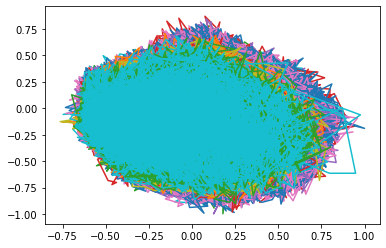

In [20]:
color_map = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink', 'tab:olive', 'tab:cyan', 'tab:purple']
for j in range(len(hidden_states_norm[0])):
#     lbl = f'States Class {int(Y_new[j])}'
    plt.plot(hidden_states[0][j, ::15, 0], hidden_states[0][j, :, 1], color_map[int(Y[j])])
plt.show()    
# plt.legend()

In [78]:
model_kwargs = dict(
    filt=32,
    kernLength=16,
    ds_rate=8,
    n_rnn=200,
    n_rnn2=200,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0001, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)
model = make_model(X, Y_class.shape[-1], **model_kwargs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 36, 2718)]        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 36, 2718, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 2703, 32)      544       
_________________________________________________________________
batch_normalization_4 (Batch (None, 36, 2703, 32)      128       
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 1, 2703, 32)       1184      
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 2703, 32)       128       
_________________________________________________________________
activation_3 (Activation)    (None, 1, 2703, 32)       0   

In [79]:
N_SPLITS = 5
hist, acc, y_pred, y_true = kfold_pred(sess_id,X[learned],rule[learned],name='rd_l' ,verbose=1)

/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


	Split 1 of 5
Epoch 1/150
41/41 [==============================] - 9s 98ms/step - loss: 4.1234 - accuracy: 0.1683 - val_loss: 3.8410 - val_accuracy: 0.1818

Epoch 00001: val_accuracy improved from -inf to 0.18182, saving model to rd_l_sra3_1_j_050_00+_split0.h5
Epoch 2/150
41/41 [==============================] - 2s 53ms/step - loss: 3.1164 - accuracy: 0.4651 - val_loss: 3.7459 - val_accuracy: 0.1030

Epoch 00002: val_accuracy did not improve from 0.18182
Epoch 3/150
41/41 [==============================] - 2s 53ms/step - loss: 2.7534 - accuracy: 0.5937 - val_loss: 3.6718 - val_accuracy: 0.1030

Epoch 00003: val_accuracy did not improve from 0.18182
Epoch 4/150
41/41 [==============================] - 2s 52ms/step - loss: 2.6763 - accuracy: 0.6297 - val_loss: 3.6607 - val_accuracy: 0.1152

Epoch 00004: val_accuracy did not improve from 0.18182
Epoch 5/150
41/41 [==============================] - 2s 52ms/step - loss: 2.5908 - accuracy: 0.6253 - val_loss: 3.4483 - val_accuracy: 0.1515

E

41/41 [==============================] - 2s 52ms/step - loss: 1.6684 - accuracy: 0.9034 - val_loss: 2.3010 - val_accuracy: 0.6303

Epoch 00040: val_accuracy did not improve from 0.83636
Epoch 41/150
41/41 [==============================] - 2s 52ms/step - loss: 1.7081 - accuracy: 0.8742 - val_loss: 1.8335 - val_accuracy: 0.8303

Epoch 00041: val_accuracy did not improve from 0.83636
Epoch 42/150
41/41 [==============================] - 2s 53ms/step - loss: 1.6742 - accuracy: 0.8933 - val_loss: 1.9233 - val_accuracy: 0.7394

Epoch 00042: val_accuracy did not improve from 0.83636
Epoch 43/150
41/41 [==============================] - 2s 52ms/step - loss: 1.6505 - accuracy: 0.9028 - val_loss: 1.8429 - val_accuracy: 0.8000

Epoch 00043: val_accuracy did not improve from 0.83636
Epoch 44/150
41/41 [==============================] - 2s 53ms/step - loss: 1.6759 - accuracy: 0.8750 - val_loss: 1.8720 - val_accuracy: 0.7394

Epoch 00044: val_accuracy did not improve from 0.83636
Epoch 45/150
41/41

41/41 [==============================] - 2s 52ms/step - loss: 1.5507 - accuracy: 0.9102 - val_loss: 1.8426 - val_accuracy: 0.7879

Epoch 00081: val_accuracy did not improve from 0.84848
Epoch 82/150
41/41 [==============================] - 2s 53ms/step - loss: 1.4837 - accuracy: 0.9426 - val_loss: 1.7729 - val_accuracy: 0.8182

Epoch 00082: val_accuracy did not improve from 0.84848
Epoch 83/150
41/41 [==============================] - 2s 53ms/step - loss: 1.4860 - accuracy: 0.9452 - val_loss: 1.9167 - val_accuracy: 0.7939

Epoch 00083: val_accuracy did not improve from 0.84848
Epoch 84/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5153 - accuracy: 0.9243 - val_loss: 1.8137 - val_accuracy: 0.8182

Epoch 00084: val_accuracy did not improve from 0.84848
Epoch 85/150
41/41 [==============================] - 2s 53ms/step - loss: 1.4582 - accuracy: 0.9637 - val_loss: 1.7938 - val_accuracy: 0.8121

Epoch 00085: val_accuracy did not improve from 0.84848
Epoch 86/150
41/41

41/41 [==============================] - 2s 54ms/step - loss: 1.4645 - accuracy: 0.9506 - val_loss: 1.7987 - val_accuracy: 0.8000

Epoch 00122: val_accuracy did not improve from 0.85455
Epoch 123/150
41/41 [==============================] - 2s 53ms/step - loss: 1.4452 - accuracy: 0.9521 - val_loss: 1.9484 - val_accuracy: 0.7394

Epoch 00123: val_accuracy did not improve from 0.85455
Epoch 124/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4417 - accuracy: 0.9549 - val_loss: 2.0039 - val_accuracy: 0.7515

Epoch 00124: val_accuracy did not improve from 0.85455
Epoch 125/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4978 - accuracy: 0.9086 - val_loss: 1.8387 - val_accuracy: 0.8000

Epoch 00125: val_accuracy did not improve from 0.85455
Epoch 126/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3956 - accuracy: 0.9669 - val_loss: 1.8947 - val_accuracy: 0.8000

Epoch 00126: val_accuracy did not improve from 0.85455
Epoch 127/150


41/41 [==============================] - 2s 52ms/step - loss: 2.1637 - accuracy: 0.7721 - val_loss: 2.5505 - val_accuracy: 0.6121

Epoch 00011: val_accuracy did not improve from 0.73333
Epoch 12/150
41/41 [==============================] - 2s 52ms/step - loss: 2.1726 - accuracy: 0.7838 - val_loss: 2.1199 - val_accuracy: 0.7515

Epoch 00012: val_accuracy improved from 0.73333 to 0.75152, saving model to rd_l_sra3_1_j_050_00+_split1.h5
Epoch 13/150
41/41 [==============================] - 2s 52ms/step - loss: 2.1048 - accuracy: 0.7861 - val_loss: 2.9430 - val_accuracy: 0.3758

Epoch 00013: val_accuracy did not improve from 0.75152
Epoch 14/150
41/41 [==============================] - 2s 52ms/step - loss: 2.1002 - accuracy: 0.7896 - val_loss: 2.2185 - val_accuracy: 0.6848

Epoch 00014: val_accuracy did not improve from 0.75152
Epoch 15/150
41/41 [==============================] - 2s 52ms/step - loss: 2.1262 - accuracy: 0.7577 - val_loss: 2.2728 - val_accuracy: 0.7152

Epoch 00015: val_acc

41/41 [==============================] - 2s 55ms/step - loss: 1.6336 - accuracy: 0.9107 - val_loss: 1.8082 - val_accuracy: 0.8303

Epoch 00051: val_accuracy improved from 0.81818 to 0.83030, saving model to rd_l_sra3_1_j_050_00+_split1.h5
Epoch 52/150
41/41 [==============================] - 2s 53ms/step - loss: 1.6918 - accuracy: 0.8684 - val_loss: 1.8390 - val_accuracy: 0.8000

Epoch 00052: val_accuracy did not improve from 0.83030
Epoch 53/150
41/41 [==============================] - 2s 52ms/step - loss: 1.6588 - accuracy: 0.8792 - val_loss: 1.8209 - val_accuracy: 0.8061

Epoch 00053: val_accuracy did not improve from 0.83030
Epoch 54/150
41/41 [==============================] - 2s 52ms/step - loss: 1.6141 - accuracy: 0.9065 - val_loss: 1.8215 - val_accuracy: 0.8061

Epoch 00054: val_accuracy did not improve from 0.83030
Epoch 55/150
41/41 [==============================] - 2s 52ms/step - loss: 1.6141 - accuracy: 0.8870 - val_loss: 1.8285 - val_accuracy: 0.8121

Epoch 00055: val_acc

41/41 [==============================] - 2s 52ms/step - loss: 1.4963 - accuracy: 0.9606 - val_loss: 1.8696 - val_accuracy: 0.7879

Epoch 00092: val_accuracy did not improve from 0.83030
Epoch 93/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4934 - accuracy: 0.9445 - val_loss: 1.9236 - val_accuracy: 0.7879

Epoch 00093: val_accuracy did not improve from 0.83030
Epoch 94/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4808 - accuracy: 0.9414 - val_loss: 1.8958 - val_accuracy: 0.7576

Epoch 00094: val_accuracy did not improve from 0.83030
Epoch 95/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4929 - accuracy: 0.9344 - val_loss: 1.9223 - val_accuracy: 0.7818

Epoch 00095: val_accuracy did not improve from 0.83030
Epoch 96/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4951 - accuracy: 0.9385 - val_loss: 1.9951 - val_accuracy: 0.7152

Epoch 00096: val_accuracy did not improve from 0.83030
Epoch 97/150
41/41

41/41 [==============================] - 2s 52ms/step - loss: 1.3693 - accuracy: 0.9824 - val_loss: 1.8563 - val_accuracy: 0.7879

Epoch 00133: val_accuracy did not improve from 0.83030
Epoch 134/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3730 - accuracy: 0.9713 - val_loss: 1.7917 - val_accuracy: 0.8121

Epoch 00134: val_accuracy did not improve from 0.83030
Epoch 135/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3902 - accuracy: 0.9782 - val_loss: 1.8777 - val_accuracy: 0.7758

Epoch 00135: val_accuracy did not improve from 0.83030
Epoch 136/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4052 - accuracy: 0.9540 - val_loss: 1.8507 - val_accuracy: 0.7818

Epoch 00136: val_accuracy did not improve from 0.83030
Epoch 137/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3796 - accuracy: 0.9734 - val_loss: 1.9340 - val_accuracy: 0.7576

Epoch 00137: val_accuracy did not improve from 0.83030
Epoch 138/150


41/41 [==============================] - 2s 52ms/step - loss: 1.5588 - accuracy: 0.9197 - val_loss: 2.1333 - val_accuracy: 0.7030

Epoch 00062: val_accuracy did not improve from 0.79394
Epoch 63/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5642 - accuracy: 0.9245 - val_loss: 1.9280 - val_accuracy: 0.7636

Epoch 00063: val_accuracy did not improve from 0.79394
Epoch 64/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5173 - accuracy: 0.9409 - val_loss: 1.9303 - val_accuracy: 0.7515

Epoch 00064: val_accuracy did not improve from 0.79394
Epoch 65/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5180 - accuracy: 0.9220 - val_loss: 1.8818 - val_accuracy: 0.7818

Epoch 00065: val_accuracy did not improve from 0.79394
Epoch 66/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5686 - accuracy: 0.9195 - val_loss: 1.9286 - val_accuracy: 0.7636

Epoch 00066: val_accuracy did not improve from 0.79394
Epoch 67/150
41/41

41/41 [==============================] - 2s 52ms/step - loss: 1.4488 - accuracy: 0.9623 - val_loss: 1.9088 - val_accuracy: 0.7636

Epoch 00103: val_accuracy did not improve from 0.80000
Epoch 104/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4718 - accuracy: 0.9425 - val_loss: 1.9629 - val_accuracy: 0.7697

Epoch 00104: val_accuracy did not improve from 0.80000
Epoch 105/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4506 - accuracy: 0.9385 - val_loss: 1.9288 - val_accuracy: 0.7697

Epoch 00105: val_accuracy did not improve from 0.80000
Epoch 106/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4805 - accuracy: 0.9393 - val_loss: 2.0334 - val_accuracy: 0.7333

Epoch 00106: val_accuracy did not improve from 0.80000
Epoch 107/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4489 - accuracy: 0.9450 - val_loss: 1.9173 - val_accuracy: 0.7939

Epoch 00107: val_accuracy did not improve from 0.80000
Epoch 108/150


41/41 [==============================] - 2s 52ms/step - loss: 1.4025 - accuracy: 0.9596 - val_loss: 2.0056 - val_accuracy: 0.7212

Epoch 00144: val_accuracy did not improve from 0.80000
Epoch 145/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3860 - accuracy: 0.9680 - val_loss: 1.9184 - val_accuracy: 0.7636

Epoch 00145: val_accuracy did not improve from 0.80000
Epoch 146/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3745 - accuracy: 0.9697 - val_loss: 1.9881 - val_accuracy: 0.7576

Epoch 00146: val_accuracy did not improve from 0.80000
Epoch 147/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3904 - accuracy: 0.9609 - val_loss: 1.8744 - val_accuracy: 0.7697

Epoch 00147: val_accuracy did not improve from 0.80000
Epoch 148/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3728 - accuracy: 0.9660 - val_loss: 1.9794 - val_accuracy: 0.7333

Epoch 00148: val_accuracy did not improve from 0.80000
Epoch 149/150



Epoch 00032: val_accuracy did not improve from 0.80606
Epoch 33/150
41/41 [==============================] - 2s 52ms/step - loss: 1.8733 - accuracy: 0.8359 - val_loss: 1.8833 - val_accuracy: 0.8182

Epoch 00033: val_accuracy improved from 0.80606 to 0.81818, saving model to rd_l_sra3_1_j_050_00+_split3.h5
Epoch 34/150
41/41 [==============================] - 2s 52ms/step - loss: 1.8097 - accuracy: 0.8522 - val_loss: 2.4632 - val_accuracy: 0.6000

Epoch 00034: val_accuracy did not improve from 0.81818
Epoch 35/150
41/41 [==============================] - 2s 52ms/step - loss: 1.8095 - accuracy: 0.8349 - val_loss: 2.2337 - val_accuracy: 0.6667

Epoch 00035: val_accuracy did not improve from 0.81818
Epoch 36/150
41/41 [==============================] - 2s 52ms/step - loss: 1.7869 - accuracy: 0.8623 - val_loss: 1.9468 - val_accuracy: 0.7818

Epoch 00036: val_accuracy did not improve from 0.81818
Epoch 37/150
41/41 [==============================] - 2s 52ms/step - loss: 1.7751 - accuracy: 0


Epoch 00073: val_accuracy improved from 0.81818 to 0.82424, saving model to rd_l_sra3_1_j_050_00+_split3.h5
Epoch 74/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5474 - accuracy: 0.9049 - val_loss: 1.8754 - val_accuracy: 0.7758

Epoch 00074: val_accuracy did not improve from 0.82424
Epoch 75/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5290 - accuracy: 0.9240 - val_loss: 1.8261 - val_accuracy: 0.7818

Epoch 00075: val_accuracy did not improve from 0.82424
Epoch 76/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5382 - accuracy: 0.9196 - val_loss: 1.8836 - val_accuracy: 0.7636

Epoch 00076: val_accuracy did not improve from 0.82424
Epoch 77/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4851 - accuracy: 0.9507 - val_loss: 1.8199 - val_accuracy: 0.8121

Epoch 00077: val_accuracy did not improve from 0.82424
Epoch 78/150
41/41 [==============================] - 2s 52ms/step - loss: 1.4951 - accuracy: 0


Epoch 00004: val_accuracy improved from 0.11585 to 0.21951, saving model to rd_l_sra3_1_j_050_00+_split4.h5
Epoch 5/150
41/41 [==============================] - 2s 52ms/step - loss: 2.4694 - accuracy: 0.7183 - val_loss: 3.4345 - val_accuracy: 0.3598

Epoch 00005: val_accuracy improved from 0.21951 to 0.35976, saving model to rd_l_sra3_1_j_050_00+_split4.h5
Epoch 6/150
41/41 [==============================] - 2s 52ms/step - loss: 2.3976 - accuracy: 0.7005 - val_loss: 2.9862 - val_accuracy: 0.4634

Epoch 00006: val_accuracy improved from 0.35976 to 0.46341, saving model to rd_l_sra3_1_j_050_00+_split4.h5
Epoch 7/150
41/41 [==============================] - 2s 52ms/step - loss: 2.3594 - accuracy: 0.7456 - val_loss: 3.3714 - val_accuracy: 0.3171

Epoch 00007: val_accuracy did not improve from 0.46341
Epoch 8/150
41/41 [==============================] - 2s 52ms/step - loss: 2.3510 - accuracy: 0.7230 - val_loss: 2.4999 - val_accuracy: 0.6037

Epoch 00008: val_accuracy improved from 0.46341 

41/41 [==============================] - 2s 52ms/step - loss: 1.6394 - accuracy: 0.8996 - val_loss: 1.9307 - val_accuracy: 0.7500

Epoch 00044: val_accuracy did not improve from 0.79268
Epoch 45/150
41/41 [==============================] - 2s 53ms/step - loss: 1.6953 - accuracy: 0.8689 - val_loss: 2.2520 - val_accuracy: 0.6768

Epoch 00045: val_accuracy did not improve from 0.79268
Epoch 46/150
41/41 [==============================] - 2s 53ms/step - loss: 1.6886 - accuracy: 0.8908 - val_loss: 1.8903 - val_accuracy: 0.7988

Epoch 00046: val_accuracy improved from 0.79268 to 0.79878, saving model to rd_l_sra3_1_j_050_00+_split4.h5
Epoch 47/150
41/41 [==============================] - 2s 52ms/step - loss: 1.6121 - accuracy: 0.9152 - val_loss: 1.9021 - val_accuracy: 0.7866

Epoch 00047: val_accuracy did not improve from 0.79878
Epoch 48/150
41/41 [==============================] - 2s 54ms/step - loss: 1.6496 - accuracy: 0.9016 - val_loss: 1.9355 - val_accuracy: 0.7744

Epoch 00048: val_acc

41/41 [==============================] - 2s 52ms/step - loss: 1.5147 - accuracy: 0.9545 - val_loss: 2.0514 - val_accuracy: 0.7317

Epoch 00085: val_accuracy did not improve from 0.79878
Epoch 86/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5417 - accuracy: 0.9365 - val_loss: 2.0367 - val_accuracy: 0.7256

Epoch 00086: val_accuracy did not improve from 0.79878
Epoch 87/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5222 - accuracy: 0.9331 - val_loss: 1.9875 - val_accuracy: 0.7500

Epoch 00087: val_accuracy did not improve from 0.79878
Epoch 88/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5365 - accuracy: 0.9309 - val_loss: 1.9884 - val_accuracy: 0.7866

Epoch 00088: val_accuracy did not improve from 0.79878
Epoch 89/150
41/41 [==============================] - 2s 52ms/step - loss: 1.5173 - accuracy: 0.9531 - val_loss: 1.9788 - val_accuracy: 0.7744

Epoch 00089: val_accuracy did not improve from 0.79878
Epoch 90/150
41/41

41/41 [==============================] - 2s 54ms/step - loss: 1.3517 - accuracy: 0.9888 - val_loss: 1.9606 - val_accuracy: 0.7744

Epoch 00126: val_accuracy did not improve from 0.82317
Epoch 127/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3810 - accuracy: 0.9681 - val_loss: 1.8509 - val_accuracy: 0.7622

Epoch 00127: val_accuracy did not improve from 0.82317
Epoch 128/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3848 - accuracy: 0.9634 - val_loss: 1.8791 - val_accuracy: 0.7500

Epoch 00128: val_accuracy did not improve from 0.82317
Epoch 129/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3868 - accuracy: 0.9702 - val_loss: 1.8411 - val_accuracy: 0.8110

Epoch 00129: val_accuracy did not improve from 0.82317
Epoch 130/150
41/41 [==============================] - 2s 52ms/step - loss: 1.3422 - accuracy: 0.9863 - val_loss: 1.8808 - val_accuracy: 0.7683

Epoch 00130: val_accuracy did not improve from 0.82317
Epoch 131/150


In [80]:
hist, acc, y_pred, y_true = kfold_pred(sess_id,X[unlearned],rule[unlearned],name='rd_ul' ,verbose=1)

	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Epoch 1/150
16/16 [==============================] - 5s 174ms/step - loss: 4.5789 - accuracy: 0.0555 - val_loss: 3.9073 - val_accuracy: 0.2000

Epoch 00001: val_accuracy improved from -inf to 0.20000, saving model to rd_ul_sra3_1_j_050_00+_split0.h5
Epoch 2/150
16/16 [==============================] - 1s 55ms/step - loss: 3.7670 - accuracy: 0.1600 - val_loss: 3.8552 - val_accuracy: 0.2308

Epoch 00002: val_accuracy improved from 0.20000 to 0.23077, saving model to rd_ul_sra3_1_j_050_00+_split0.h5
Epoch 3/150
16/16 [==============================] - 1s 67ms/step - loss: 3.4631 - accuracy: 0.2599 - val_loss: 3.8038 - val_accuracy: 0.2000

Epoch 00003: val_accuracy did not improve from 0.23077
Epoch 4/150
16/16 [==============================] - 1s 54ms/step - loss: 3.1597 - accuracy: 0.3921 - val_loss: 3.7778 - val_accuracy: 0.1077

Epoch 00004: val_accuracy did not improve from 0.23077
Epoch 5/150
16/16 [==============================] - 1s 54ms/step - loss: 3.1426 - accuracy: 0.3504 - 

Epoch 40/150
16/16 [==============================] - 1s 54ms/step - loss: 2.0949 - accuracy: 0.7226 - val_loss: 2.9964 - val_accuracy: 0.4308

Epoch 00040: val_accuracy improved from 0.41538 to 0.43077, saving model to rd_ul_sra3_1_j_050_00+_split0.h5
Epoch 41/150
16/16 [==============================] - 1s 54ms/step - loss: 2.0886 - accuracy: 0.7465 - val_loss: 2.8294 - val_accuracy: 0.3538

Epoch 00041: val_accuracy did not improve from 0.43077
Epoch 42/150
16/16 [==============================] - 1s 54ms/step - loss: 2.0673 - accuracy: 0.7348 - val_loss: 3.0323 - val_accuracy: 0.3538

Epoch 00042: val_accuracy did not improve from 0.43077
Epoch 43/150
16/16 [==============================] - 1s 54ms/step - loss: 2.0796 - accuracy: 0.7241 - val_loss: 2.7713 - val_accuracy: 0.4000

Epoch 00043: val_accuracy did not improve from 0.43077
Epoch 44/150
16/16 [==============================] - 1s 54ms/step - loss: 2.0502 - accuracy: 0.7262 - val_loss: 2.6202 - val_accuracy: 0.4769

Epoch 


Epoch 00080: val_accuracy did not improve from 0.47692
Epoch 81/150
16/16 [==============================] - 1s 54ms/step - loss: 1.6046 - accuracy: 0.9765 - val_loss: 2.8977 - val_accuracy: 0.4308

Epoch 00081: val_accuracy did not improve from 0.47692
Epoch 82/150
16/16 [==============================] - 1s 54ms/step - loss: 1.6295 - accuracy: 0.9538 - val_loss: 2.8978 - val_accuracy: 0.3846

Epoch 00082: val_accuracy did not improve from 0.47692
Epoch 83/150
16/16 [==============================] - 1s 54ms/step - loss: 1.6529 - accuracy: 0.9363 - val_loss: 3.1358 - val_accuracy: 0.3538

Epoch 00083: val_accuracy did not improve from 0.47692
Epoch 84/150
16/16 [==============================] - 1s 54ms/step - loss: 1.6749 - accuracy: 0.9228 - val_loss: 3.0151 - val_accuracy: 0.4154

Epoch 00084: val_accuracy did not improve from 0.47692
Epoch 85/150
16/16 [==============================] - 1s 54ms/step - loss: 1.7588 - accuracy: 0.8532 - val_loss: 2.8300 - val_accuracy: 0.4308

Epoc


Epoch 00121: val_accuracy did not improve from 0.49231
Epoch 122/150
16/16 [==============================] - 1s 54ms/step - loss: 1.5966 - accuracy: 0.8990 - val_loss: 2.9005 - val_accuracy: 0.4615

Epoch 00122: val_accuracy did not improve from 0.49231
Epoch 123/150
16/16 [==============================] - 1s 54ms/step - loss: 1.5456 - accuracy: 0.9287 - val_loss: 2.7391 - val_accuracy: 0.5077

Epoch 00123: val_accuracy improved from 0.49231 to 0.50769, saving model to rd_ul_sra3_1_j_050_00+_split0.h5
Epoch 124/150
16/16 [==============================] - 1s 54ms/step - loss: 1.5326 - accuracy: 0.9468 - val_loss: 2.7211 - val_accuracy: 0.5077

Epoch 00124: val_accuracy did not improve from 0.50769
Epoch 125/150
16/16 [==============================] - 1s 54ms/step - loss: 1.4992 - accuracy: 0.9785 - val_loss: 2.8798 - val_accuracy: 0.4769

Epoch 00125: val_accuracy did not improve from 0.50769
Epoch 126/150
16/16 [==============================] - 1s 54ms/step - loss: 1.4959 - accur


Epoch 00011: val_accuracy did not improve from 0.20312
Epoch 12/150
16/16 [==============================] - 1s 54ms/step - loss: 2.6979 - accuracy: 0.4995 - val_loss: 3.2455 - val_accuracy: 0.2188

Epoch 00012: val_accuracy improved from 0.20312 to 0.21875, saving model to rd_ul_sra3_1_j_050_00+_split1.h5
Epoch 13/150
16/16 [==============================] - 1s 54ms/step - loss: 2.6949 - accuracy: 0.5164 - val_loss: 3.7662 - val_accuracy: 0.0781

Epoch 00013: val_accuracy did not improve from 0.21875
Epoch 14/150
16/16 [==============================] - 1s 54ms/step - loss: 2.5380 - accuracy: 0.5721 - val_loss: 3.8205 - val_accuracy: 0.2031

Epoch 00014: val_accuracy did not improve from 0.21875
Epoch 15/150
16/16 [==============================] - 1s 54ms/step - loss: 2.6978 - accuracy: 0.4570 - val_loss: 3.5864 - val_accuracy: 0.1094

Epoch 00015: val_accuracy did not improve from 0.21875
Epoch 16/150
16/16 [==============================] - 1s 54ms/step - loss: 2.5683 - accuracy: 

Epoch 92/150
16/16 [==============================] - 1s 53ms/step - loss: 1.6684 - accuracy: 0.9402 - val_loss: 2.7332 - val_accuracy: 0.4688

Epoch 00092: val_accuracy did not improve from 0.53125
Epoch 93/150
16/16 [==============================] - 1s 53ms/step - loss: 1.7756 - accuracy: 0.8667 - val_loss: 3.3770 - val_accuracy: 0.2656

Epoch 00093: val_accuracy did not improve from 0.53125
Epoch 94/150
16/16 [==============================] - 1s 54ms/step - loss: 1.6461 - accuracy: 0.9521 - val_loss: 3.0348 - val_accuracy: 0.3906

Epoch 00094: val_accuracy did not improve from 0.53125
Epoch 95/150
16/16 [==============================] - 1s 54ms/step - loss: 1.7363 - accuracy: 0.8780 - val_loss: 2.8690 - val_accuracy: 0.4844

Epoch 00095: val_accuracy did not improve from 0.53125
Epoch 96/150
16/16 [==============================] - 1s 54ms/step - loss: 1.6775 - accuracy: 0.9043 - val_loss: 2.9327 - val_accuracy: 0.4375

Epoch 00096: val_accuracy did not improve from 0.53125
Epoch

16/16 [==============================] - 1s 54ms/step - loss: 1.5999 - accuracy: 0.9202 - val_loss: 2.7717 - val_accuracy: 0.4062

Epoch 00133: val_accuracy did not improve from 0.53125
Epoch 134/150
16/16 [==============================] - 1s 54ms/step - loss: 1.5916 - accuracy: 0.9563 - val_loss: 2.6572 - val_accuracy: 0.4375

Epoch 00134: val_accuracy did not improve from 0.53125
Epoch 135/150
16/16 [==============================] - 1s 54ms/step - loss: 1.5770 - accuracy: 0.9760 - val_loss: 2.6784 - val_accuracy: 0.4531

Epoch 00135: val_accuracy did not improve from 0.53125
Epoch 136/150
16/16 [==============================] - 1s 53ms/step - loss: 1.5300 - accuracy: 0.9583 - val_loss: 2.9363 - val_accuracy: 0.4062

Epoch 00136: val_accuracy did not improve from 0.53125
Epoch 137/150
16/16 [==============================] - 1s 54ms/step - loss: 1.5875 - accuracy: 0.9455 - val_loss: 2.8926 - val_accuracy: 0.4688

Epoch 00137: val_accuracy did not improve from 0.53125
Epoch 138/150



Epoch 00021: val_accuracy did not improve from 0.43750
Epoch 22/150
16/16 [==============================] - 1s 54ms/step - loss: 2.4890 - accuracy: 0.5131 - val_loss: 2.8622 - val_accuracy: 0.3438

Epoch 00022: val_accuracy did not improve from 0.43750
Epoch 23/150
16/16 [==============================] - 1s 53ms/step - loss: 2.3972 - accuracy: 0.6528 - val_loss: 3.4294 - val_accuracy: 0.2500

Epoch 00023: val_accuracy did not improve from 0.43750
Epoch 24/150
16/16 [==============================] - 1s 54ms/step - loss: 2.3025 - accuracy: 0.7245 - val_loss: 2.8425 - val_accuracy: 0.3750

Epoch 00024: val_accuracy did not improve from 0.43750
Epoch 25/150
16/16 [==============================] - 1s 53ms/step - loss: 2.3777 - accuracy: 0.6052 - val_loss: 3.4039 - val_accuracy: 0.2656

Epoch 00025: val_accuracy did not improve from 0.43750
Epoch 26/150
16/16 [==============================] - 1s 54ms/step - loss: 2.3534 - accuracy: 0.6238 - val_loss: 2.6252 - val_accuracy: 0.4062

Epoc


Epoch 00062: val_accuracy did not improve from 0.46875
Epoch 63/150
16/16 [==============================] - 1s 54ms/step - loss: 1.8402 - accuracy: 0.8607 - val_loss: 2.8002 - val_accuracy: 0.4531

Epoch 00063: val_accuracy did not improve from 0.46875
Epoch 64/150
16/16 [==============================] - 1s 54ms/step - loss: 1.8057 - accuracy: 0.8815 - val_loss: 2.7983 - val_accuracy: 0.3906

Epoch 00064: val_accuracy did not improve from 0.46875
Epoch 65/150
16/16 [==============================] - 1s 54ms/step - loss: 1.7382 - accuracy: 0.9162 - val_loss: 2.7325 - val_accuracy: 0.4531

Epoch 00065: val_accuracy did not improve from 0.46875
Epoch 66/150
16/16 [==============================] - 1s 54ms/step - loss: 1.7770 - accuracy: 0.9182 - val_loss: 2.8968 - val_accuracy: 0.4219

Epoch 00066: val_accuracy did not improve from 0.46875
Epoch 67/150
16/16 [==============================] - 1s 53ms/step - loss: 1.7490 - accuracy: 0.9196 - val_loss: 2.9201 - val_accuracy: 0.4531

Epoc


Epoch 00103: val_accuracy did not improve from 0.50000
Epoch 104/150
16/16 [==============================] - 1s 54ms/step - loss: 1.7016 - accuracy: 0.9226 - val_loss: 2.9700 - val_accuracy: 0.4375

Epoch 00104: val_accuracy did not improve from 0.50000
Epoch 105/150
16/16 [==============================] - 1s 54ms/step - loss: 1.6261 - accuracy: 0.9530 - val_loss: 2.8492 - val_accuracy: 0.4219

Epoch 00105: val_accuracy did not improve from 0.50000
Epoch 106/150
16/16 [==============================] - 1s 60ms/step - loss: 1.6398 - accuracy: 0.9378 - val_loss: 2.9047 - val_accuracy: 0.3750

Epoch 00106: val_accuracy did not improve from 0.50000
Epoch 107/150
16/16 [==============================] - 1s 53ms/step - loss: 1.6173 - accuracy: 0.9595 - val_loss: 3.0436 - val_accuracy: 0.4219

Epoch 00107: val_accuracy did not improve from 0.50000
Epoch 108/150
16/16 [==============================] - 1s 54ms/step - loss: 1.5956 - accuracy: 0.9625 - val_loss: 2.9423 - val_accuracy: 0.4062



Epoch 00144: val_accuracy did not improve from 0.50000
Epoch 145/150
16/16 [==============================] - 1s 54ms/step - loss: 1.5305 - accuracy: 0.9511 - val_loss: 2.9224 - val_accuracy: 0.3750

Epoch 00145: val_accuracy did not improve from 0.50000
Epoch 146/150
16/16 [==============================] - 1s 54ms/step - loss: 1.4776 - accuracy: 0.9895 - val_loss: 2.8920 - val_accuracy: 0.4375

Epoch 00146: val_accuracy did not improve from 0.50000
Epoch 147/150
16/16 [==============================] - 1s 54ms/step - loss: 1.4866 - accuracy: 0.9704 - val_loss: 2.9522 - val_accuracy: 0.3906

Epoch 00147: val_accuracy did not improve from 0.50000
Epoch 148/150
16/16 [==============================] - 1s 54ms/step - loss: 1.4649 - accuracy: 0.9833 - val_loss: 3.1447 - val_accuracy: 0.3750

Epoch 00148: val_accuracy did not improve from 0.50000
Epoch 149/150
16/16 [==============================] - 1s 54ms/step - loss: 1.4801 - accuracy: 0.9520 - val_loss: 2.9044 - val_accuracy: 0.4375


Epoch 34/150
16/16 [==============================] - 1s 54ms/step - loss: 2.1530 - accuracy: 0.7165 - val_loss: 2.8519 - val_accuracy: 0.3125

Epoch 00034: val_accuracy did not improve from 0.48438
Epoch 35/150
16/16 [==============================] - 1s 60ms/step - loss: 2.0969 - accuracy: 0.7488 - val_loss: 3.0912 - val_accuracy: 0.3125

Epoch 00035: val_accuracy did not improve from 0.48438
Epoch 36/150
16/16 [==============================] - 1s 54ms/step - loss: 2.0926 - accuracy: 0.7707 - val_loss: 2.8932 - val_accuracy: 0.3750

Epoch 00036: val_accuracy did not improve from 0.48438
Epoch 37/150
16/16 [==============================] - 1s 54ms/step - loss: 2.1431 - accuracy: 0.7202 - val_loss: 2.8308 - val_accuracy: 0.3125

Epoch 00037: val_accuracy did not improve from 0.48438
Epoch 38/150
16/16 [==============================] - 1s 54ms/step - loss: 2.0058 - accuracy: 0.8073 - val_loss: 2.8662 - val_accuracy: 0.3438

Epoch 00038: val_accuracy did not improve from 0.48438
Epoch

16/16 [==============================] - 1s 53ms/step - loss: 1.4849 - accuracy: 0.9797 - val_loss: 3.2287 - val_accuracy: 0.3281

Epoch 00116: val_accuracy did not improve from 0.48438
Epoch 117/150
16/16 [==============================] - 1s 54ms/step - loss: 1.5172 - accuracy: 0.9609 - val_loss: 3.0929 - val_accuracy: 0.3281

Epoch 00117: val_accuracy did not improve from 0.48438
Epoch 118/150
16/16 [==============================] - 1s 54ms/step - loss: 1.5603 - accuracy: 0.9566 - val_loss: 3.1488 - val_accuracy: 0.3281

Epoch 00118: val_accuracy did not improve from 0.48438
Epoch 119/150
16/16 [==============================] - 1s 53ms/step - loss: 1.5253 - accuracy: 0.9569 - val_loss: 3.0630 - val_accuracy: 0.3281

Epoch 00119: val_accuracy did not improve from 0.48438
Epoch 120/150
16/16 [==============================] - 1s 53ms/step - loss: 1.5188 - accuracy: 0.9531 - val_loss: 3.0981 - val_accuracy: 0.3125

Epoch 00120: val_accuracy did not improve from 0.48438
Epoch 121/150


Epoch 7/150
16/16 [==============================] - 1s 54ms/step - loss: 3.0008 - accuracy: 0.4232 - val_loss: 3.6025 - val_accuracy: 0.1875

Epoch 00007: val_accuracy did not improve from 0.25000
Epoch 8/150
16/16 [==============================] - 1s 53ms/step - loss: 3.0134 - accuracy: 0.3984 - val_loss: 3.5193 - val_accuracy: 0.2031

Epoch 00008: val_accuracy did not improve from 0.25000
Epoch 9/150
16/16 [==============================] - 1s 54ms/step - loss: 2.7883 - accuracy: 0.4901 - val_loss: 3.6118 - val_accuracy: 0.0938

Epoch 00009: val_accuracy did not improve from 0.25000
Epoch 10/150
16/16 [==============================] - 1s 54ms/step - loss: 2.7150 - accuracy: 0.5234 - val_loss: 3.6446 - val_accuracy: 0.0625

Epoch 00010: val_accuracy did not improve from 0.25000
Epoch 11/150
16/16 [==============================] - 1s 54ms/step - loss: 2.7113 - accuracy: 0.4925 - val_loss: 3.6013 - val_accuracy: 0.1250

Epoch 00011: val_accuracy did not improve from 0.25000
Epoch 12


Epoch 00087: val_accuracy did not improve from 0.53125
Epoch 88/150
16/16 [==============================] - 1s 54ms/step - loss: 1.6448 - accuracy: 0.9198 - val_loss: 2.8587 - val_accuracy: 0.4375

Epoch 00088: val_accuracy did not improve from 0.53125
Epoch 89/150
16/16 [==============================] - 1s 54ms/step - loss: 1.6278 - accuracy: 0.9224 - val_loss: 2.8219 - val_accuracy: 0.4688

Epoch 00089: val_accuracy did not improve from 0.53125
Epoch 90/150
16/16 [==============================] - 1s 60ms/step - loss: 1.6061 - accuracy: 0.9683 - val_loss: 2.7755 - val_accuracy: 0.4531

Epoch 00090: val_accuracy did not improve from 0.53125
Epoch 91/150
16/16 [==============================] - 1s 53ms/step - loss: 1.6126 - accuracy: 0.9476 - val_loss: 2.8125 - val_accuracy: 0.4062

Epoch 00091: val_accuracy did not improve from 0.53125
Epoch 92/150
16/16 [==============================] - 1s 54ms/step - loss: 1.6118 - accuracy: 0.9495 - val_loss: 2.8594 - val_accuracy: 0.4062

Epoc

Epoch 129/150
16/16 [==============================] - 1s 53ms/step - loss: 1.5103 - accuracy: 0.9656 - val_loss: 2.7880 - val_accuracy: 0.4375

Epoch 00129: val_accuracy did not improve from 0.53125
Epoch 130/150
16/16 [==============================] - 1s 53ms/step - loss: 1.5277 - accuracy: 0.9465 - val_loss: 2.7119 - val_accuracy: 0.4375

Epoch 00130: val_accuracy did not improve from 0.53125
Epoch 131/150
16/16 [==============================] - 1s 53ms/step - loss: 1.4773 - accuracy: 0.9869 - val_loss: 2.8126 - val_accuracy: 0.4844

Epoch 00131: val_accuracy did not improve from 0.53125
Epoch 132/150
16/16 [==============================] - 1s 53ms/step - loss: 1.4995 - accuracy: 0.9619 - val_loss: 2.8006 - val_accuracy: 0.4688

Epoch 00132: val_accuracy did not improve from 0.53125
Epoch 133/150
16/16 [==============================] - 1s 53ms/step - loss: 1.4930 - accuracy: 0.9627 - val_loss: 2.7037 - val_accuracy: 0.4844

Epoch 00133: val_accuracy did not improve from 0.53125


In [ ]:
model = tf.keras.models.load_model(f'rd_l_sra3_1_j_050_00+_split0.h5')
output = model.layers[10].output
factor_model = tf.keras.Model(model.input, output)
inpt = np.transpose(X[learned],(0,2,1))
XL = factor_model(X[learned])
YL = Y[learned]
pca_values = np.zeros((XL.shape[0],XL.shape[1], 32))
pca =PCA(n_components=32)
# FAs = [FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0)]
# TSNEs = [TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10)]
for i in range(XL.shape[0]):
    print(f'Trial {i}')
    trial = np.squeeze(XL[i])
    if i==0:
        pca_values[i] = pca.fit_transform(trial)
#         print('Factor Analysis')
#         pfa_values[i] = FAs[YL[i]].fit_transform(pca_values)
    else:
        pca_values[i] = pca.transform(trial)

In [91]:
factor_model.summary()
print(XL.shape)
a = np.transpose(X[learned],(0,2,1))
print(a.shape)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 2718)]        0         
_________________________________________________________________
reshape (Reshape)            (None, 36, 2718, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 2703, 32)      544       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 2703, 32)      128       
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 2703, 32)       1184      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 2703, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 1, 2703, 32)       0   

In [29]:
hidden_states = []

for i in range(N_SPLITS):
    print(f'Working on Split #{i}, Learned Trials')
    model = tf.keras.models.load_model(f'rd_l_sra3_1_j_050_00+_split{i}.h5')
    output = model.layers[10].output
    factor_model = tf.keras.Model(model.input, output)
    factors = factor_model(X[learned])
    
    pca = PCA(n_components=50)
    tmp = np.reshape(factors, (factors.shape[0] * factors.shape[1], factors.shape[2]))
    pca_values = pca.fit_transform(tmp)
    fa_values = FactorAnalysis(n_components=10, random_state=0).fit_transform(pca_values)
    tsne_values = TSNE(n_components=3,perplexity=10).fit_transform(fa_values)
    tmp = np.reshape(tsne_values, (factors.shape[0], factors.shape[1], fa_values.shape[1]))
    hidden_states.append(tmp)

Working on Split #0, Learned Trials


ValueError: cannot reshape array of size 4944 into shape (824,2,10)

In [76]:
XL = np.transpose(X[learned], (0, 2, 1))
YL = Y[learned]
pca_values = np.zeros((XL.shape[0],XL.shape[1], 32))
PCAs = [PCA(n_components=32),PCA(n_components=32),PCA(n_components=32),PCA(n_components=32),PCA(n_components=32),PCA(n_components=32),PCA(n_components=32),PCA(n_components=32)]
# FAs = [FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0),FactorAnalysis(n_components=10, random_state=0)]
# TSNEs = [TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10),TSNE(n_components=3,perplexity=10)]
for i in range(XL.shape[0]):
    print(f'Trial {i}')
    trial = np.squeeze(XL[i])
    if i==np.argmax(YL==YL[i]):
        print(f'Found first trial of class {YL[i]}')
        print('PCA')
        pca_values[i] = PCAs[YL[i]].fit_transform(trial)
#         print('Factor Analysis')
#         pfa_values[i] = FAs[YL[i]].fit_transform(pca_values)
    else:
        print('PCA')
        pca_values[i] = PCAs[YL[i]].transform(trial)
#         print('Factor Analysis')
#         pfa_values[i] = FAs[YL[i]].transform(pca_values)
#     print('tSNE')
#     ptfa_values[i] = TSNEs[YL[i]].fit_transform(fa_values)

Trial 0
Found first trial of class 4
PCA
Trial 1
PCA
Trial 2
PCA
Trial 3
Found first trial of class 0
PCA
Trial 4
PCA
Trial 5
PCA
Trial 6
PCA
Trial 7
PCA
Trial 8
PCA
Trial 9
PCA
Trial 10
PCA
Trial 11
PCA
Trial 12
PCA
Trial 13
PCA
Trial 14
PCA
Trial 15
PCA
Trial 16
PCA
Trial 17
PCA
Trial 18
PCA
Trial 19
PCA
Trial 20
PCA
Trial 21
PCA
Trial 22
PCA
Trial 23
PCA
Trial 24
PCA
Trial 25
PCA
Trial 26
PCA
Trial 27
PCA
Trial 28
PCA
Trial 29
PCA
Trial 30
PCA
Trial 31
PCA
Trial 32
PCA
Trial 33
PCA
Trial 34
PCA
Trial 35
PCA
Trial 36
PCA
Trial 37
PCA
Trial 38
PCA
Trial 39
PCA
Trial 40
PCA
Trial 41
PCA
Trial 42
PCA
Trial 43
PCA
Trial 44
PCA
Trial 45
PCA
Trial 46
PCA
Trial 47
PCA
Trial 48
PCA
Trial 49
PCA
Trial 50
PCA
Trial 51
PCA
Trial 52
PCA
Trial 53
PCA
Trial 54
PCA
Trial 55
PCA
Trial 56
PCA
Trial 57
PCA
Trial 58
PCA
Trial 59
PCA
Trial 60
PCA
Trial 61
PCA
Trial 62
PCA
Trial 63
PCA
Trial 64
PCA
Trial 65
PCA
Trial 66
PCA
Trial 67
PCA
Trial 68
PCA
Trial 69
PCA
Trial 70
PCA
Trial 71
PCA
Trial 72
PCA
Tri

Trial 762
PCA
Trial 763
PCA
Trial 764
PCA
Trial 765
PCA
Trial 766
PCA
Trial 767
PCA
Trial 768
PCA
Trial 769
PCA
Trial 770
PCA
Trial 771
PCA
Trial 772
PCA
Trial 773
PCA
Trial 774
PCA
Trial 775
PCA
Trial 776
PCA
Trial 777
PCA
Trial 778
PCA
Trial 779
PCA
Trial 780
PCA
Trial 781
PCA
Trial 782
PCA
Trial 783
PCA
Trial 784
PCA
Trial 785
PCA
Trial 786
PCA
Trial 787
PCA
Trial 788
PCA
Trial 789
PCA
Trial 790
PCA
Trial 791
PCA
Trial 792
PCA
Trial 793
PCA
Trial 794
PCA
Trial 795
PCA
Trial 796
PCA
Trial 797
PCA
Trial 798
PCA
Trial 799
PCA
Trial 800
PCA
Trial 801
PCA
Trial 802
PCA
Trial 803
PCA
Trial 804
PCA
Trial 805
PCA
Trial 806
PCA
Trial 807
PCA
Trial 808
PCA
Trial 809
PCA
Trial 810
PCA
Trial 811
PCA
Trial 812
PCA
Trial 813
PCA
Trial 814
PCA
Trial 815
PCA
Trial 816
PCA
Trial 817
PCA
Trial 818
PCA
Trial 819
PCA
Trial 820
PCA
Trial 821
PCA
Trial 822
PCA
Trial 823
PCA


In [70]:
i==np.argmax(YL==YL[i])

False

In [72]:
YL

array([4, 4, 4, 0, 4, 0, 4, 4, 0, 0, 0, 4, 4, 0, 0, 0, 4, 4, 0, 0, 4, 4,
       0, 0, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4,
       4, 0, 4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 0, 4, 0, 4, 4, 4, 4, 0, 0, 4,
       0, 4, 4, 0, 4, 4, 0, 0, 0, 7, 7, 3, 7, 3, 7, 3, 3, 3, 7, 7, 3, 7,
       7, 3, 7, 3, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 3, 7, 7, 3, 3, 3, 7,
       7, 3, 7, 7, 7, 7, 7, 7, 7, 3, 3, 7, 3, 3, 3, 7, 7, 3, 7, 3, 7, 7,
       3, 3, 7, 7, 7, 7, 7, 7, 3, 7, 3, 3, 3, 7, 3, 3, 4, 4, 0, 4, 0, 4,
       0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 4, 0, 0, 4,
       4, 4, 4, 4, 0, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 0, 4,
       0, 4, 4, 1, 1, 5, 5, 1, 1, 1, 1, 1, 5, 1, 5, 5, 5, 1, 1, 5, 5, 5,
       1, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 5, 1, 1, 1, 5, 5, 1, 1,
       1, 1, 1, 5, 1, 5, 5, 1, 1, 1, 5, 5, 1, 1, 5, 1, 5, 5, 5, 5, 1, 1,
       1, 5, 5, 1, 5, 1, 5, 1, 5, 1, 5, 5, 5, 5, 5, 1, 1, 5, 1, 1, 1, 1,
       5, 5, 1, 1, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1,

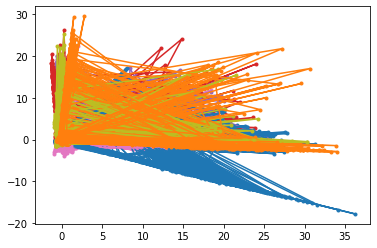

In [77]:
color_map = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink', 'tab:olive', 'tab:cyan', 'tab:purple']
for tr in range(285):
    plt.plot(pca_values[tr,:,0], pca_values[tr,:,1], '.-', color=color_map[YL[tr]])
plt.show()

In [52]:
i

286

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 36, 2718)]     0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 36, 2718)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 21, 32)         1391648   
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 21, 32)         128       
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 21, 32)         64        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 21, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 1, 21, 32)         0     